# Business Understanding and Problem Statement

## Introduction

**Context:** Customer-level data of a leading telecom firm.

**Business Features:** 
- Highly competitive market, 15-25% annual churn rate
- 5 - 10 times more costly to acquire new customer
- Customer retention is thus prioritised over customer acquisition

**Objective:** *Retaining high profitable customers is the number one business goal*

**Requirement:** Predict which customers are at high risk of churn. Build predictive models to identify customers at hih risk of churn and identify main indicators of churn.

## Defining churn

Churn is directly defined for **postpaid** customers who pay a monthly/annual bill because they inform their current operator when they wish to terminate serices.

Churn for **prepaid** customers is hard to ditect because they simply stop recharging and it isn't clear if they switched operators or if they had churned.

- **Prepaid model** is more common in India and Southeast Asia which is the target location for our current case study.

**Revenue-based churn:** Customers who have generated less than INR 4 per month in total/average/median revenue are considered to have churned.

**Usage-based churn:** Customers who have not used any of the services over a period of time. Shortcoming for using this as an indicator of churn is that it is too late by the time we identify that a person has churned. 

- We use **usage-based churn** for the current case study.

**High Value Churn:** Approximately 80% of the revenue comes from the top 20% customers (high-value customers). Hence, reduction in churn of high-value customers will reduce significant revenue leakage.

- We focus on predicting the churn only for high-value customers
- **Definition:** Customers who have recharged with an amount more than or equal to the 70th percentile of the average recharge amount in the first two months.

## Customer Behavior During Churn

Three phases of customer lifecycle:
- **Good Phase -** Customer is happy.
- **Action Phase -** General discontent with services, time to take action by the company if they wish to retain the customer.
- **Churn Phase -** Final phase where we define a customer as churned (tagging). This information is unavailable during the action months.

**Churn Definition:** No IC/OG calls and No mobile internet used in the churn phase.

## Data Understanding

**Given:** Dataset containing customer level information for a span of four consecutive months (June, July, August and September). 

**Business Objective:** Predict churn in the last month (September) using data from the first three months.

# Library and Data Imports

In [1]:
## Basic
import numpy as np
import pandas as pd
import time

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Setting display styles
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(precision=4, suppress=True)

sns.set(style="darkgrid")
sns.set_palette("Set2")
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)
pd.set_option('display.width', 1000)

## Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek

from collections import Counter

## Modelling

## PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

## Logistic Regression
from sklearn.linear_model import LogisticRegression

## Random Forest
from sklearn.ensemble import RandomForestClassifier

## Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

## XG Boost
#!pip install xgboost
import xgboost as xgb

## Cross Validation (Hyperparameter tuning)
from sklearn.model_selection import RandomizedSearchCV

## Model Evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report 


## Data Dictionary

In [2]:
data_dict = pd.read_excel("Data+Dictionary-+Telecom+Churn+Case+Study.xlsx")
display(data_dict)

Acronyms                                           Descriptions
0   MOBILE_NUMBER                              Customer phone number
1       CIRCLE_ID  Telecom circle area to which the customer belo...
2             LOC           Local calls - within same telecom circle
3             STD             STD calls - outside the calling circle
4              IC                                     Incoming calls
5              OG                                     Outgoing calls
6             T2T  Operator T to T, i.e. within same operator (mo...
7         T2M                    Operator T to other operator mobile
8         T2O                Operator T to other operator fixed line
9         T2F                         Operator T to fixed lines of T
10        T2C                     Operator T to it’s own call center
11       ARPU                               Average revenue per user
12        MOU                         Minutes of usage - voice calls
13        AON      Age on network - number of days the customer i...
14       ONNET     All kind of calls within the same operator net...
15     OFFNET       All kind of calls outside the operator T network
16           ROAM  Indicates that customer is in roaming zone dur...
17         SPL                                         Special calls
18        ISD                                              ISD calls
19       RECH                                               Recharge
20        NUM                                                 Number
21        AMT                               Amount in local currency
22        MAX                                                Maximum
23       DATA                                        Mobile internet
24         3G                                             3G network
25         AV                                                Average
26        VOL                   Mobile internet usage volume (in MB)
27         2G                                             2G network
28        PCK                 Prepaid service schemes called - PACKS
29      NIGHT         Scheme to use during specific night hours only
30    MONTHLY      Service schemes with validity equivalent to a ...
31      SACHET     Service schemes with validity smaller than a m...
32        *.6                              KPI for the month of June
33        *.7                              KPI for the month of July
34        *.8                            KPI for the month of August
35        *.9                         KPI for the month of September
36        FB_USER  Service scheme to avail services of Facebook a...
37        VBC      Volume based cost - when no specific scheme is...

## Telecom Customer Data

In [3]:
data0 = pd.read_csv("telecom_churn_data.csv")
print("\nThe shape of the dataframe is:", data0.shape)
print()
display(data0.head(3))


The shape of the dataframe is: (99999, 226)



mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7 last_date_of_month_8 last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_t2c_mou_9  loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  loc_og_mou_9  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2t_mou_9  std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2m_mou_9  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_t2f_mou_9  \
0     7000842753        109          0.0000          0.0000          0.0000            6/30/2014            7/31/2014            8/31/2014            9/30/2014 197.3850 214.8160 213.8030  21.1000          NaN          NaN       0.0000          NaN           NaN           NaN        0.0000           NaN            NaN            NaN         0.0000            NaN            NaN            NaN         0.0000            NaN               NaN               NaN            0.0000               NaN               NaN               NaN            0.0000               NaN               NaN               NaN            0.0000               NaN               NaN               NaN            0.0000               NaN           NaN           NaN        0.0000           NaN               NaN               NaN            0.0000               NaN               NaN               NaN            0.0000               NaN               NaN               NaN            0.0000               NaN   
1     7001865778        109          0.0000          0.0000          0.0000            6/30/2014            7/31/2014            8/31/2014            9/30/2014  34.0470 355.0740 268.3210  86.2850      24.1100      78.6800       7.6800      18.3400       15.7400       99.8400      304.7600       53.7600         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000           23.8800           74.5600            7.6800           18.3400           11.5100           75.9400          291.8600           53.7600            0.0000            0.0000            0.0000            0.0000            0.0000            2.9100            0.0000            0.0000       35.3900      150.5100      299.5400       72.1100            0.2300            4.1100            0.0000            0.0000            0.0000            0.4600            0.1300            0.0000            0.0000            0.0000            0.0000            0.0000   
2     7001625959        109          0.0000          0.0000          0.0000            6/30/2014            7/31/2014            8/31/2014            9/30/2014 167.6900 189.0580 210.2260 290.7140      11.5400      55.2400      37.2600      74.8100      143.3300      220.5900      208.3600      118.9100         0.0000         0.0000         0.0000        38.4900         0.0000         0.0000         0.0000        70.9400            7.1900           28.7400           13.5800           14.3900           29.3400           16.8600           38.4600           28.1600           24.1100           21.7900           15.6100           22.2400            0.0000          135.5400           45.7600            0.4800       60.6600       67.4100       67.6600       64.8100            4.3400           26.4900           22.5800            8.7600           41.8100           67.4100           75.5300            9.2800            1.4800           14.7600           22.8300            0.0000   

   std_og_t2c_mou_6  std_og_t2c_mou_7  std_og_t2c_mou_

### Explaining Dataset

Exploring the columns from the customer level dataset provided and using information from the data dictionary to understand the abbreviations, following are our observations regarding the columns present: 
- mobile_number
- circle_id
- aon: age on network
- 31*4= 124 mou (Minutes of Usage) columns for 4 months and 3 consolidated columns (`loc_og_t2o_mou`, `std_og_t2o_mou`, `loc_ic_t2o_mou`)
- 12 date columns related to different last recharges for 4 different months
- 12 arpu (Average Revenue Per User) columns across different segments for 4 different months
- 36 columns contains information about different recharges done by the user for each of these 4 months:
> - `total_rech_num_*` - no. of total recharges
> - `total_rech_amt_*` - amount of total recharge
> - `total_rech_data_*` - no. of total data recharges (2g + 3g
> - `max_rech_data_*` - maximum amount of data recharge
> - `av_rech_amt_data_*` - average amount of each data recharge
> - `count_rech_2g/3g_*` - count of 2g and 3g recharges in each month
> - `last_day_rch_amt_*` - last recharge amount by the user
- 8 `vol_*` columns have information of consumed 2g and 3g data volume by the user for each 4 months.
- 4 `*_vbc_3g` contains info about volume based 3g consumption by the users.
- 4 `night_pck_user_*` categorical features contain if a user has active night pack for a month.
- 16 `sachet_* and monthly_*` columns have information about the no. of monthly/sachet packs used by users.
- 4 `fb_user_*` categorical features contain if a user has fb service activated or not.

In [4]:
display(data0.describe())

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou     arpu_6     arpu_7     arpu_8     arpu_9  onnet_mou_6  onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_t2c_mou_9  loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  loc_og_mou_9  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2t_mou_9  std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2m_mou_9  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_t2f_mou_9  std_og_t2c_mou_6  std_og_t2c_mou_7  std_og_t2c_mou_8  std_og_t2c_mou_9  \
count      99999.0000 99999.0000      98981.0000      98981.0000      98981.0000 99999.0000 99999.0000 99999.0000 99999.0000   96062.0000   96140.0000   94621.0000   92254.0000    96062.0000    96140.0000    94621.0000    92254.0000     96062.0000     96140.0000     94621.0000     92254.0000     96062.0000     96140.0000     94621.0000     92254.0000        96062.0000        96140.0000        94621.0000        92254.0000        96062.0000        96140.0000        94621.0000        92254.0000        96062.0000        96140.0000        94621.0000        92254.0000        96062.0000        96140.0000        94621.0000        92254.0000    96062.0000    96140.0000    94621.0000    92254.0000        96062.0000        96140.0000        94621.0000        92254.0000        96062.0000        96140.0000        94621.0000        92254.0000        96062.0000        96140.0000        94621.0000        92254.0000        96062.0000        96140.0000        94621.0000        92254.0000   
mean  7001207270.3875   109.0000          0.0000          0.0000          0.0000   282.9874   278.5366   279.1547   261.6451     132.3959     133.6708     133.0181     130.3023      197.9356      197.0451      196.5748      190.3372         9.9500         7.1499         7.2930         6.3438        13.9113         9.8187         9.9719         8.5555           47.1008           46.4730           45.8878           44.5844           93.3421           91.3971           91.7551           90.4632            3.7510            3.7930            3.6780            3.6551            1.1231            1.3685            1.4338            1.2327      144.2012      141.6705      141.3282      138.7100           79.8299           83.2996           83.2827           82.3429           87.2996           90.8041           89.8384           86.2766            1.1290            1.1150            1.0678            1.0424            0.0000            0.0000            0.0000            0.0000   
std       695669.3863     0.0000          0.0000          0.0000          0.0000   328.4398   338.1563   344.4748   341.9986     297.2074     308.7941     308.9516     308.4777      316.8516      325.8628      327.1707      319.3961        72.8254        73.4479        68.4025        57.1375        71.4432        58.4558        64.7132        58.4382          150.8564          155.3187          151.1848          147.9954          162.7805          157.4923          156.5370          158.6815           14.2304           14.2650           13.2710           13.4575            5.4489            7.5334            6.7833            5.6190      251.7515      248.7311      245.9143      245.9345          252.4765          263.6310          265.4861          267.1850          255.6179          269.3479          271.7578          261.4074            7.9850            8.5994            7.9060            8.2618            0.0000            0.0000            0.0000            0.0000   
min   7000000074.0000   109.0000          0.0000        

# Data Preprocessing

**Process flow:** 
- Tag churn customers and drop columns from the September (last) month since information from that month will be unavailable during action phase and hence cannot be used.
- Filter high-value customers
- Drop index columns
- Handle missing values

## Churn Identification (Target Variable Creation)

Churned customers are tagged as 1 in the `churn` column and the loyal customers are tagged 0. The criteria for defining a customer as churned is that they haven't made any incoming or outgoing calls and have not used mobile internet even once during the churn phase (month 9). 

In [5]:
# Columns corresponding to month 9 (Churn Phase)
cols_sept = data0.columns[data0.columns.str.contains(('_9|sep'))]
display(cols_sept)

Index(['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'sep_vbc_3g'], dty

Four columns containing summary of incoming calls, outgoing calls, 2g data and 3g data can be used to determine if a customer churned. They are:
- `total_ic_mou_9`
- `total_og_mou_9`
- `vol_2g_mb_9`
- `vol_3g_mb_9`

In [6]:
# Check whether there are null values in any of the above mentioned columns
nulls = data0.total_ic_mou_9.isna().sum()
nulls += data0.total_og_mou_9.isna().sum()
nulls += data0.vol_2g_mb_9.isna().sum()
nulls += data0.vol_3g_mb_9.isna().sum()
print("Total number of nulls in the determining columns are:", nulls)

Total number of nulls in the determining columns are: 0


In [7]:
# Create a `Churn` Column
data0['Churn'] = 0
data0.loc[(data0.total_ic_mou_9== 0) & (data0.total_og_mou_9== 0) & (data0.vol_2g_mb_9== 0) & (data0.vol_3g_mb_9== 0), 'Churn'] = 1
print("\nChurn (Target Variable) Percentage of Value Counts:\n")
print(round(100*data0.Churn.value_counts(normalize=True),2))


Churn (Target Variable) Percentage of Value Counts:

0   89.8100
1   10.1900
Name: Churn, dtype: float64


We observe that there is data imbalance in the target variable. We shall verify if the models used are properly classifying the minority class, else we shall handle class imbalance appropriately. 

Now we drop all columns containing information from the month of September. 

In [8]:
## Dropping September columns to avoid information leakage from Churn Phase to Action Phase

data0.drop(columns = cols_sept, inplace = True)
print("Shape of the dataframe after dropping September columns is:", data0.shape)

Shape of the dataframe after dropping September columns is: (99999, 172)


## Dropping Index Columns

We first check whether there are any duplicates present using the row indeces and then drop those columns because they aren't of any other use in the analysis.

In [9]:
# Checking for duplicate entry
data0['mobile_number'].duplicated().any()

False

In [10]:
data0['circle_id'].value_counts()

109    99999
Name: circle_id, dtype: int64

In [11]:
print("Shape of the dataset before dropping index columns:", data0.shape)
data0.drop(columns = ['mobile_number', 'circle_id'], inplace = True)
print("Shape of the dataset after dropping index columns:", data0.shape)

Shape of the dataset before dropping index columns: (99999, 172)
Shape of the dataset after dropping index columns: (99999, 170)


## Handling Missing Values

In [12]:
# Percentage of missing values
print("\nPercentage of missing values in each column is:\n")
print(round(100*data0.isnull().mean().sort_values(ascending=False), 2))


Percentage of missing values in each column is:

total_rech_data_6          74.8500
night_pck_user_6           74.8500
arpu_2g_6                  74.8500
arpu_3g_6                  74.8500
av_rech_amt_data_6         74.8500
count_rech_3g_6            74.8500
max_rech_data_6            74.8500
count_rech_2g_6            74.8500
date_of_last_rech_data_6   74.8500
fb_user_6                  74.8500
night_pck_user_7           74.4300
date_of_last_rech_data_7   74.4300
arpu_3g_7                  74.4300
fb_user_7                  74.4300
av_rech_amt_data_7         74.4300
count_rech_3g_7            74.4300
count_rech_2g_7            74.4300
total_rech_data_7          74.4300
max_rech_data_7            74.4300
arpu_2g_7                  74.4300
count_rech_2g_8            73.6600
total_rech_data_8          73.6600
count_rech_3g_8            73.6600
av_rech_amt_data_8         73.6600
max_rech_data_8            73.6600
arpu_3g_8                  73.6600
date_of_last_rech_data_8   73.6600
arpu_

**Assumption:** The missing values corresponding to recharge amounts or recharge data are because the customer hadn't made any recharge hence imputation of these columns with 0 is ideal.

This can be verified from the fact that the row indeces of the missing values match for columns containing last recharge date, total amount of recharge, average amount of recharge, maximum recharge amount, etc., for each month.

In [13]:
## Identifying recharge columns
cols_rech = data0.columns[data0.columns.str.contains(('rech'))]
display(data0[cols_rech].head())

total_rech_num_6  total_rech_num_7  total_rech_num_8  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  max_rech_amt_7  max_rech_amt_8 date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8 date_of_last_rech_data_6 date_of_last_rech_data_7 date_of_last_rech_data_8  total_rech_data_6  total_rech_data_7  total_rech_data_8  max_rech_data_6  max_rech_data_7  max_rech_data_8  count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  count_rech_3g_6  count_rech_3g_7  count_rech_3g_8  av_rech_amt_data_6  av_rech_amt_data_7  av_rech_amt_data_8
0                 4                 3                 2               362               252               252             252             252             252           6/21/2014           7/16/2014            8/8/2014                6/21/2014                7/16/2014                 8/8/2014             1.0000             1.0000             1.0000         252.0000         252.0000         252.0000           0.0000           0.0000           0.0000           1.0000           1.0000           1.0000            252.0000            252.0000            252.0000
1                 4                 9                11                74               384               283              44             154              65           6/29/2014           7/31/2014           8/28/2014                      NaN                7/25/2014                8/10/2014                NaN             1.0000             2.0000              NaN         154.0000          25.0000              NaN           1.0000           2.0000              NaN           0.0000           0.0000                 NaN            154.0000             50.0000
2                 5                 4                 2               168               315               116              86             200              86           6/17/2014           7/24/2014           8/14/2014                      NaN                      NaN                      NaN                NaN                NaN                NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN                 NaN                 NaN                 NaN
3                10                11                18               230               310               601              60              50              50           6/28/2014           7/31/2014           8/31/2014                      NaN                      NaN                      NaN                NaN                NaN                NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN                 NaN                 NaN                 NaN
4                 5                 6                 3               196               350               287              56             110             110           6/26/2014           7/28/2014            8/9/2014                 6/4/2014                      NaN                      NaN             1.0000                NaN                NaN          56.0000              NaN              NaN           1.0000              NaN              NaN           0.0000              NaN              NaN             56.0000                 NaN                 NaN

Nulls matrices containing only the null rows for June as an example:


total_rech_data_6  night_pck_user_6  arpu_2g_6  arpu_3g_6  av_rech_amt_data_6  count_rech_3g_6  max_rech_data_6  count_rech_2g_6 date_of_last_rech_data_6  fb_user_6
1                NaN               NaN        NaN        NaN                 NaN              NaN              NaN              NaN                      NaN        NaN
2                NaN               NaN        NaN        NaN                 NaN              NaN              NaN              NaN                      NaN        NaN
3                NaN               NaN        NaN        NaN                 NaN              NaN              NaN              NaN                      NaN        NaN
5                NaN               NaN        NaN        NaN                 NaN              NaN              NaN              NaN                      NaN        NaN
6                NaN               NaN        NaN        NaN                 NaN              NaN              NaN              NaN                      NaN        NaN


Number of rows containing Nulls in June is: 74846
Number of rows containing Nulls in July is: 74428
Number of rows containing Nulls in August is: 73660



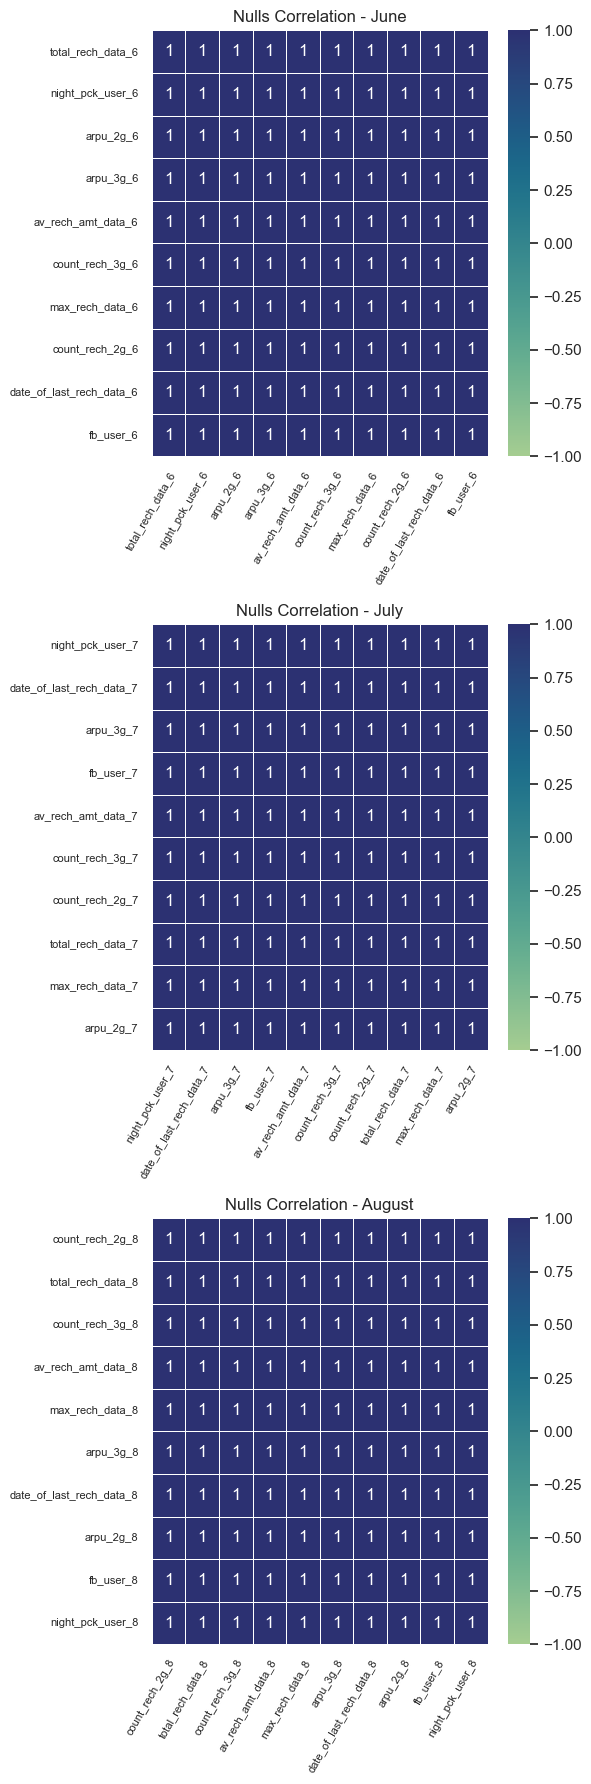

In [14]:
## Checking if the row indeces of the missing values match
cols_june = ['total_rech_data_6', 'night_pck_user_6','arpu_2g_6', 'arpu_3g_6', 'av_rech_amt_data_6', 
             'count_rech_3g_6', 'max_rech_data_6', 'count_rech_2g_6', 'date_of_last_rech_data_6', 'fb_user_6']

cols_july = ['night_pck_user_7', 'date_of_last_rech_data_7', 'arpu_3g_7', 'fb_user_7', 'av_rech_amt_data_7', 
             'count_rech_3g_7', 'count_rech_2g_7', 'total_rech_data_7', 'max_rech_data_7', 'arpu_2g_7']

cols_aug = ['count_rech_2g_8', 'total_rech_data_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'max_rech_data_8', 
            'arpu_3g_8', 'date_of_last_rech_data_8', 'arpu_2g_8', 'fb_user_8', 'night_pck_user_8']

# Create a sub-dataframes containing rows with null values in the columns
nulls_june = data0[cols_june].loc[data0[cols_june].isnull().any(axis=1)]
nulls_july = data0[cols_july].loc[data0[cols_july].isnull().any(axis=1)]
nulls_aug = data0[cols_aug].loc[data0[cols_aug].isnull().any(axis=1)]

print("Nulls matrices containing only the null rows for June as an example:")
display(nulls_june.head())
print()
print("Number of rows containing Nulls in June is:", nulls_june.shape[0])
print("Number of rows containing Nulls in July is:", nulls_july.shape[0])
print("Number of rows containing Nulls in August is:", nulls_aug.shape[0])
print()

# Validating the initial assumption by checking for correlation between nulls

# Create correlation matrices
corr_matrix_june = data0[cols_june].isnull().corr()
corr_matrix_july = data0[cols_july].isnull().corr()
corr_matrix_aug = data0[cols_aug].isnull().corr()

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 18))

# Plot the heatmaps
sns.heatmap(corr_matrix_june, annot=True, ax=axes[0], cmap='crest', vmin=-1, vmax=1, linewidths=0.5)
sns.heatmap(corr_matrix_july, annot=True, ax=axes[1], cmap='crest', vmin=-1, vmax=1, linewidths=0.5)
sns.heatmap(corr_matrix_aug, annot=True, ax=axes[2], cmap='crest', vmin=-1, vmax=1, linewidths=0.5)

axes[0].set_title('Nulls Correlation - June')
axes[1].set_title('Nulls Correlation - July')
axes[2].set_title('Nulls Correlation - August')
for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right", rotation_mode="anchor")
    ax.tick_params(labelsize=8)

plt.tight_layout()

plt.show()

We can therefore conclude that the missing values in these columns are not at random and they are related. It is highly probable that this is because the user hasn't actually made any recharge. Hence it is logical for us to impute these missing values with 0.

In [15]:
# Filling the missing values with 0 for the recharge columns
for col in cols_june + cols_july + cols_aug:
    data0[col].fillna(0, inplace= True)

# Displaying nulls percentage again.
print(round(100*data0.isnull().mean().sort_values(ascending=False), 2))

loc_og_t2c_mou_8           5.3800
roam_ic_mou_8              5.3800
std_og_t2m_mou_8           5.3800
loc_og_mou_8               5.3800
std_og_t2f_mou_8           5.3800
loc_ic_t2t_mou_8           5.3800
std_ic_t2t_mou_8           5.3800
loc_og_t2f_mou_8           5.3800
std_og_t2c_mou_8           5.3800
loc_og_t2m_mou_8           5.3800
loc_ic_t2f_mou_8           5.3800
std_og_mou_8               5.3800
loc_og_t2t_mou_8           5.3800
std_ic_t2m_mou_8           5.3800
roam_og_mou_8              5.3800
loc_ic_mou_8               5.3800
isd_og_mou_8               5.3800
isd_ic_mou_8               5.3800
loc_ic_t2m_mou_8           5.3800
std_ic_mou_8               5.3800
std_ic_t2o_mou_8           5.3800
ic_others_8                5.3800
spl_ic_mou_8               5.3800
og_others_8                5.3800
std_og_t2t_mou_8           5.3800
onnet_mou_8                5.3800
std_ic_t2f_mou_8           5.3800
offnet_mou_8               5.3800
spl_og_mou_8               5.3800
og_others_6   

We see similar pattern in the missing values of `mou_*` columns for each month, i.e., the percentage of missing values for each month is exactly same. We can now generate similar heatmaps for those columns to verify if their missing value occurances are also related, in which case we can impute them with 0.


Number of rows containing Nulls in June is: 3937
Number of rows containing Nulls in July is: 3859
Number of rows containing Nulls in August is: 5378



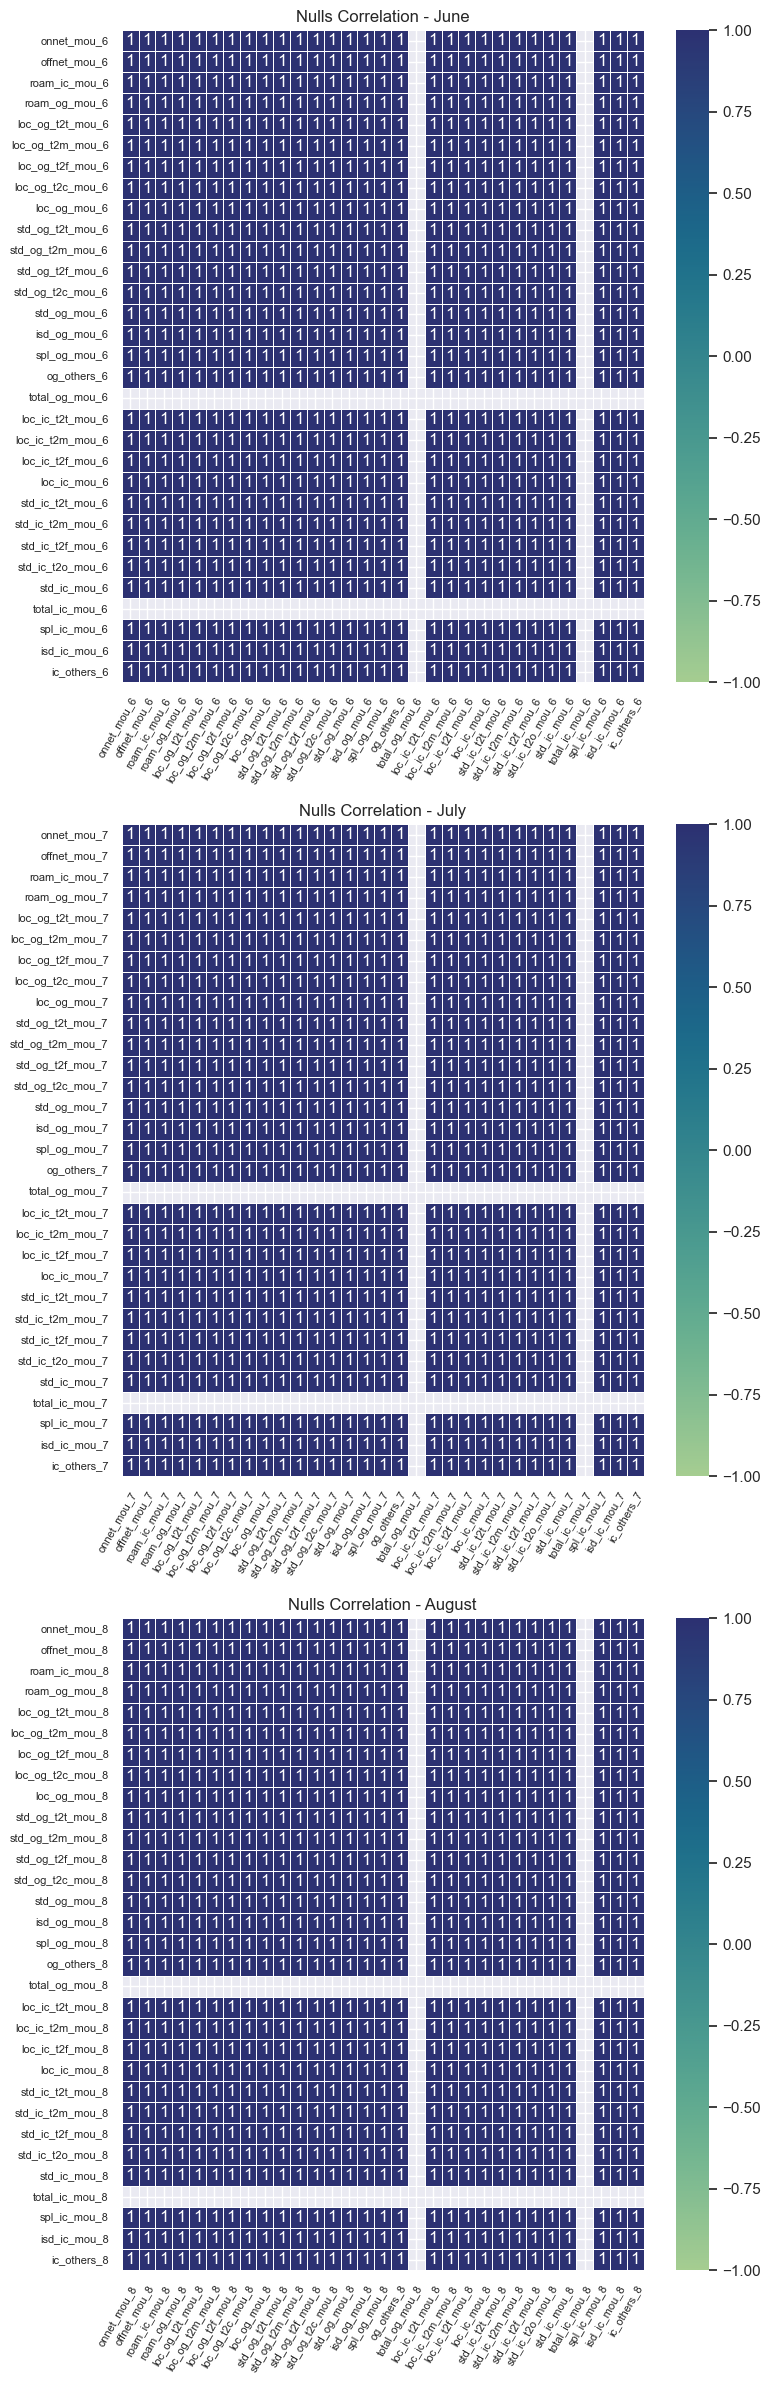

In [16]:
## Repeating the process with mou and other columns

cols_june =  data0.columns[data0.columns.str.endswith(('mou_6', '_others_6'))]
cols_july = data0.columns[data0.columns.str.endswith(('mou_7', '_others_7'))]
cols_aug = data0.columns[data0.columns.str.endswith(('mou_8', '_others_8'))]

# Create a sub-dataframes containing rows with null values in the columns
nulls_june = data0[cols_june].loc[data0[cols_june].isnull().any(axis=1)]
nulls_july = data0[cols_july].loc[data0[cols_july].isnull().any(axis=1)]
nulls_aug = data0[cols_aug].loc[data0[cols_aug].isnull().any(axis=1)]

print()
print("Number of rows containing Nulls in June is:", nulls_june.shape[0])
print("Number of rows containing Nulls in July is:", nulls_july.shape[0])
print("Number of rows containing Nulls in August is:", nulls_aug.shape[0])
print()

# Validating the initial assumption by checking for correlation between nulls

# Create correlation matrices
corr_matrix_june = data0[cols_june].isnull().corr()
corr_matrix_july = data0[cols_july].isnull().corr()
corr_matrix_aug = data0[cols_aug].isnull().corr()

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 24))

# Plot the heatmaps
sns.heatmap(corr_matrix_june, annot=True, ax=axes[0], cmap='crest', vmin=-1, vmax=1, linewidths=0.5)
sns.heatmap(corr_matrix_july, annot=True, ax=axes[1], cmap='crest', vmin=-1, vmax=1, linewidths=0.5)
sns.heatmap(corr_matrix_aug, annot=True, ax=axes[2], cmap='crest', vmin=-1, vmax=1, linewidths=0.5)

axes[0].set_title('Nulls Correlation - June')
axes[1].set_title('Nulls Correlation - July')
axes[2].set_title('Nulls Correlation - August')
for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right", rotation_mode="anchor")
    ax.tick_params(labelsize=8)

plt.tight_layout()

plt.show()

Note that the columns `total_og_mou_*` and `total_ic_mou_*` are blank. This could be because they don't have any null values and they already have the value 0 in them. Checking that in the following code:

In [17]:
cols_june_total = nulls_june.loc[:, nulls_june.columns.str.contains(('total'))].describe()
cols_july_total = nulls_july.loc[:, nulls_july.columns.str.contains(('total'))].describe()
cols_aug_total = nulls_aug.loc[:, nulls_aug.columns.str.contains(('total'))].describe()

display(pd.concat([cols_june_total, cols_july_total, cols_aug_total], axis = 1))

total_og_mou_6  total_ic_mou_6  total_og_mou_7  total_ic_mou_7  total_og_mou_8  total_ic_mou_8
count       3937.0000       3937.0000       3859.0000       3859.0000       5378.0000       5378.0000
mean           0.0000          0.0000          0.0000          0.0000          0.0000          0.0000
std            0.0000          0.0000          0.0000          0.0000          0.0000          0.0000
min            0.0000          0.0000          0.0000          0.0000          0.0000          0.0000
25%            0.0000          0.0000          0.0000          0.0000          0.0000          0.0000
50%            0.0000          0.0000          0.0000          0.0000          0.0000          0.0000
75%            0.0000          0.0000          0.0000          0.0000          0.0000          0.0000
max            0.0000          0.0000          0.0000          0.0000          0.0000          0.0000

Since all the null values actually correspond to columns containing the total of 0 mou, we can confidently impute the missing values with 0.

In [18]:
# Filling the missing values with 0 for the recharge columns
for col in list(cols_june) + list(cols_july) + list(cols_aug):
    data0[col].fillna(0, inplace= True)

# Displaying nulls percentage again.
print(round(100*data0.isnull().mean().sort_values(ascending=False), 2))

date_of_last_rech_8        3.6200
date_of_last_rech_7        1.7700
date_of_last_rech_6        1.6100
last_date_of_month_8       1.1000
loc_og_t2o_mou             1.0200
loc_ic_t2o_mou             1.0200
std_og_t2o_mou             1.0200
last_date_of_month_7       0.6000
date_of_last_rech_data_7   0.0000
max_rech_amt_8             0.0000
last_day_rch_amt_6         0.0000
last_day_rch_amt_7         0.0000
last_day_rch_amt_8         0.0000
date_of_last_rech_data_6   0.0000
total_rech_data_6          0.0000
date_of_last_rech_data_8   0.0000
max_rech_amt_6             0.0000
total_rech_data_7          0.0000
total_rech_data_8          0.0000
max_rech_data_6            0.0000
max_rech_data_7            0.0000
max_rech_data_8            0.0000
count_rech_2g_6            0.0000
max_rech_amt_7             0.0000
total_rech_amt_6           0.0000
total_rech_amt_8           0.0000
total_rech_amt_7           0.0000
std_ic_mou_8               0.0000
total_ic_mou_6             0.0000
total_ic_mou_7

### Dropping Redundant Columns

We note that there still are missing values in `date_of_last_rech_*`, `last_date_of_month_8`and `*_t2o_mou` columns. We will now evaluate what to do with each of these columns/missing values.

1. `last_date_of_month_8` has missing values. `last_date_of_month_*` columns in fact only mention what is the last date of that month. They could've been intermediate columns in creating the `aon` column which contains the number of days a user has been on network. Hence they don't have any significance after the creation of `aon` and can be dropped.
2. `date_of_last_rech_*` columns also have missing values. But in the presence of `aon` column, they don't add any additional value to our analysis. Hence these can be dropped as well.
3. `*_t2o_mou` columns contain missing values, we can explore them further.

Dropping the first two sets of columns and then analyzing `*_t2o_mou` columns.

In [19]:
cols_to_drop = data0.columns[data0.columns.str.contains(('date'))]
print("We are dropping the following", len(cols_to_drop), "date columns.\n")
display(cols_to_drop)
print("\nShape of the dataset before dropping date columns:", data0.shape)
data0.drop(columns = cols_to_drop, inplace = True)
print("\nShape of the dataset after dropping date columns:", data0.shape)

We are dropping the following 9 date columns.



Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'], dtype='object')


Shape of the dataset before dropping date columns: (99999, 170)

Shape of the dataset after dropping date columns: (99999, 161)


In [20]:
cols = data0.columns[data0.columns.str.contains(('_t2o_mou'))]

# Unique value information
column_info = pd.DataFrame({
    'Column': data0[cols].columns,
    'Unique Values': data0[cols].nunique(),
    'Value': data0[cols].loc[0,:]
}).reset_index(drop=True)

display(column_info)

Column  Unique Values  Value
0    loc_og_t2o_mou              1 0.0000
1    std_og_t2o_mou              1 0.0000
2    loc_ic_t2o_mou              1 0.0000
3  std_ic_t2o_mou_6              1 0.0000
4  std_ic_t2o_mou_7              1 0.0000
5  std_ic_t2o_mou_8              1 0.0000

We notice that there is no variability in the data in the above columns. They all have only one unique value which is 0 and the rest are null values which would indicate they haven't actually had any `mou` and we'd have to impute those with 0 as well. Therefore, it is justified to drop these columns.

In [21]:
print("We are dropping the following", len(cols), "t2o_mou columns.\n")
display(cols)
print("\nShape of the dataset before dropping t20_mou columns:", data0.shape)
data0.drop(columns = cols, inplace = True)
print("\nShape of the dataset after dropping t2o_mou columns:", data0.shape)

We are dropping the following 6 t2o_mou columns.



Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'], dtype='object')


Shape of the dataset before dropping t20_mou columns: (99999, 161)

Shape of the dataset after dropping t2o_mou columns: (99999, 155)


In [22]:
# Checking the percentage of missing values again
print("\nPercentage of missing values in each column is:\n")
print(round(100*data0.isnull().mean().sort_values(ascending=False), 2))


Percentage of missing values in each column is:

arpu_6               0.0000
total_rech_data_7    0.0000
max_rech_amt_6       0.0000
max_rech_amt_7       0.0000
max_rech_amt_8       0.0000
last_day_rch_amt_6   0.0000
last_day_rch_amt_7   0.0000
last_day_rch_amt_8   0.0000
total_rech_data_6    0.0000
total_rech_data_8    0.0000
count_rech_3g_8      0.0000
max_rech_data_6      0.0000
max_rech_data_7      0.0000
max_rech_data_8      0.0000
count_rech_2g_6      0.0000
count_rech_2g_7      0.0000
count_rech_2g_8      0.0000
count_rech_3g_6      0.0000
total_rech_amt_8     0.0000
total_rech_amt_7     0.0000
total_rech_amt_6     0.0000
total_rech_num_8     0.0000
std_ic_mou_8         0.0000
total_ic_mou_6       0.0000
total_ic_mou_7       0.0000
total_ic_mou_8       0.0000
spl_ic_mou_6         0.0000
spl_ic_mou_7         0.0000
spl_ic_mou_8         0.0000
isd_ic_mou_6         0.0000
isd_ic_mou_7         0.0000
isd_ic_mou_8         0.0000
ic_others_6          0.0000
ic_others_7          0.000

Hence, we finally have a dataset containing 155 columns and all the missing values handled with out business knowledge and understanding. We proceed with filtering out the high value customers who are our main target of the analysis and consider any other forms of feature selection/feature engineering at a later step.

## Filtering High-Value Customers

High-value customers are defined as those customers who have recharged with an amount greater than or equal to the 70th percentile of average recharge amount in the first two months (good phase).

- To use this definition and identify high-value customers, we first need to create a column containing the average recharge amounts in the first two months.
- We would then be able to use the cutoff as 70th percentile to get our filtered dataset.

In [23]:
## Identifying recharge columns
cols_rech = data0.columns[data0.columns.str.contains(('rech'))]
display(data0[cols_rech].head())

total_rech_num_6  total_rech_num_7  total_rech_num_8  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  total_rech_data_6  total_rech_data_7  total_rech_data_8  max_rech_data_6  max_rech_data_7  max_rech_data_8  count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  count_rech_3g_6  count_rech_3g_7  count_rech_3g_8  av_rech_amt_data_6  av_rech_amt_data_7  av_rech_amt_data_8
0                 4                 3                 2               362               252               252             252             252             252             1.0000             1.0000             1.0000         252.0000         252.0000         252.0000           0.0000           0.0000           0.0000           1.0000           1.0000           1.0000            252.0000            252.0000            252.0000
1                 4                 9                11                74               384               283              44             154              65             0.0000             1.0000             2.0000           0.0000         154.0000          25.0000           0.0000           1.0000           2.0000           0.0000           0.0000           0.0000              0.0000            154.0000             50.0000
2                 5                 4                 2               168               315               116              86             200              86             0.0000             0.0000             0.0000           0.0000           0.0000           0.0000           0.0000           0.0000           0.0000           0.0000           0.0000           0.0000              0.0000              0.0000              0.0000
3                10                11                18               230               310               601              60              50              50             0.0000             0.0000             0.0000           0.0000           0.0000           0.0000           0.0000           0.0000           0.0000           0.0000           0.0000           0.0000              0.0000              0.0000              0.0000
4                 5                 6                 3               196               350               287              56             110             110             1.0000             0.0000             0.0000          56.0000           0.0000           0.0000           1.0000           0.0000           0.0000           0.0000           0.0000           0.0000             56.0000              0.0000              0.0000

Note that there are two types of recharges that a user could make:
1. Regular recharge for the account (general packs/call balance, etc.) - This information is given in `total_rech_amt_*` columns.
2. Data recharge for 2g/3g data - The number of times such a recharge has been performed is given in `total_rech_data_*` columns and the average value of each such recharge is given in `av_rech_amt_data_*` columns

There is a change in terminology for the `total_rech_amt` and `total_rech_data` columns, this can be observed from the values and it hasn't been explicitly stated. 

In [24]:
# Calculating total recharge amount for data in each month

data0['total_rech_amt_data_6']= data0.total_rech_data_6 * data0.av_rech_amt_data_6
data0['total_rech_amt_data_7']= data0.total_rech_data_7 * data0.av_rech_amt_data_7
data0['total_rech_amt_data_8']= data0.total_rech_data_8 * data0.av_rech_amt_data_8

# Calculating average recharge amount for month 6 and 7 combined
data0['avg_rech_amt_6_7']= (data0.total_rech_amt_data_6 + data0.total_rech_amt_data_7 + 
                            data0.total_rech_amt_6 + data0.total_rech_amt_7)/2

In [25]:
# Taking top 70 percentile customers as High Value customers
data_hvc= data0[data0.avg_rech_amt_6_7 > np.percentile(data0['avg_rech_amt_6_7'], 70)].copy()

# Checking shape
print("Shape of the dataframe containing the high value customers is:", data_hvc.shape)

Shape of the dataframe containing the high value customers is: (29953, 159)


Since we have created new columns to filter out high-value customers, we must ensure there are no columns with redundant information.

In [26]:
## Identifying recharge columns
cols_rech = data_hvc.columns[data_hvc.columns.str.contains(('rech'))]
display(data_hvc[cols_rech].head(3))

total_rech_num_6  total_rech_num_7  total_rech_num_8  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  total_rech_data_6  total_rech_data_7  total_rech_data_8  max_rech_data_6  max_rech_data_7  max_rech_data_8  count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  count_rech_3g_6  count_rech_3g_7  count_rech_3g_8  av_rech_amt_data_6  av_rech_amt_data_7  av_rech_amt_data_8  total_rech_amt_data_6  total_rech_amt_data_7  total_rech_amt_data_8  avg_rech_amt_6_7
0                 4                 3                 2               362               252               252             252             252             252             1.0000             1.0000             1.0000         252.0000         252.0000         252.0000           0.0000           0.0000           0.0000           1.0000           1.0000           1.0000            252.0000            252.0000            252.0000               252.0000               252.0000               252.0000          559.0000
7                 5                 5                 7              1580               790              3638            1580             790            1580             0.0000             0.0000             0.0000           0.0000           0.0000           0.0000           0.0000           0.0000           0.0000           0.0000           0.0000           0.0000              0.0000              0.0000              0.0000                 0.0000                 0.0000                 0.0000         1185.0000
8                19                21                14               437               601               120              90             154              30             0.0000             2.0000             3.0000           0.0000         154.0000          23.0000           0.0000           2.0000           3.0000           0.0000           0.0000           0.0000              0.0000            177.0000             69.0000                 0.0000               354.0000               207.0000          696.0000

- `total_rech_num_*` columns contains total number of normal recharges made in the corresponding month.
- `total_rech_amt_*` columns contains total value of normal recharges made in the corresponding month.
- `max_rech_amt_*` columns contains maximum value of normal recharges made in the corresponding month.
<br>

- `total_rech_data_*` columns contains total number of data recharges made in the corresponding month.
- `max_rech_data_*` columns contains maximum value of data recharges made in the corresponding month.
- `count_rech_2g_*` contains the number of 2g data recharges made in the corresponding month.
- `count_rech_3g_*` contains the number of 3g data recharges made in the corresponding month.
- `av_rech_amt_data_*` contains the average value of the data recharge made in the corresponding month.
- `total_rech_amt_data_*` contains the total value of the data recharge made in the corresponding month. They have been created by us.
<br>

- `avg_rech_amt_6_7` contains the average recharge amount of both normal and data recharges done in the months june and july combined.

Based on the above observations, we verify if sum of `count_rech_2g_*` and `count_rech_3g_*` columns actually adds up to `total_rech_data_*` in which case we can drop the `total_rech_data_*` column.

We also drop the `av_rech_amt_data_*` which contains redundant information.

We also drop `avg_rech_amt_6_7` column to avoid the issue of multicollinearity since it is a derived column created only for the purpose of filtering out high-value customers

In [27]:
if (data_hvc['count_rech_2g_6'] + data_hvc['count_rech_3g_6'] == data_hvc['total_rech_data_6']).all():
    if (data_hvc['count_rech_2g_7'] + data_hvc['count_rech_3g_7'] == data_hvc['total_rech_data_7']).all():
        if (data_hvc['count_rech_2g_8'] + data_hvc['count_rech_3g_8'] == data_hvc['total_rech_data_8']).all():
            print("Assumption that total_rech_data is the sum of count_2g and count_3g is verified for all three months")

Assumption that total_rech_data is the sum of count_2g and count_3g is verified for all three months


Dropping columns as mentioned earlier.

In [28]:
cols_to_drop = data_hvc.columns[data_hvc.columns.str.contains(('total_rech_data_'))]
print("We are dropping the following", len(cols_to_drop), "columns.\n")
display(cols_to_drop)
print("\nShape of the dataset before dropping columns:", data_hvc.shape)
data_hvc.drop(columns = cols_to_drop, inplace = True)
print("\nShape of the dataset after dropping columns:", data_hvc.shape)

We are dropping the following 3 columns.



Index(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8'], dtype='object')


Shape of the dataset before dropping columns: (29953, 159)

Shape of the dataset after dropping columns: (29953, 156)


In [29]:
cols_to_drop = data_hvc.columns[data_hvc.columns.str.contains(('av_rech_amt_data_'))]
print("We are dropping the following", len(cols_to_drop), "columns.\n")
display(cols_to_drop)
print("\nShape of the dataset before dropping columns:", data_hvc.shape)
data_hvc.drop(columns = cols_to_drop, inplace = True)
print("\nShape of the dataset after dropping columns:", data_hvc.shape)

We are dropping the following 3 columns.



Index(['av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'], dtype='object')


Shape of the dataset before dropping columns: (29953, 156)

Shape of the dataset after dropping columns: (29953, 153)


In [30]:
print("We are dropping avg_rech_amt_6_7 column.")
data_hvc.drop(columns = ['avg_rech_amt_6_7'], inplace = True)
print("\nShape of the dataset after dropping the column:", data_hvc.shape)

We are dropping avg_rech_amt_6_7 column.

Shape of the dataset after dropping the column: (29953, 152)


Now that we have filtered high-value customers and dropped all the redundant columns, we have 29,953 rows and 152 columns remaining in our dataset. We now proceed to separate categorical and numerical columns of our data.

## Categorical vs. Numerical Columns

In [31]:
# Unique value information
column_info = pd.DataFrame({
    'Column': data_hvc.columns,
    'Unique Values': data_hvc.nunique(),
    'Data Type': data_hvc.dtypes
}).sort_values(by='Unique Values').reset_index(drop=True)

display(column_info)

Column  Unique Values Data Type
0         std_og_t2c_mou_6              1   float64
1         std_og_t2c_mou_8              1   float64
2         std_og_t2c_mou_7              1   float64
3         night_pck_user_6              2   float64
4         night_pck_user_7              2   float64
5         night_pck_user_8              2   float64
6                fb_user_6              2   float64
7                fb_user_7              2   float64
8                fb_user_8              2   float64
9                    Churn              2     int64
10            monthly_2g_6              5     int64
11            monthly_2g_8              6     int64
12            monthly_2g_7              6     int64
13            monthly_3g_8             12     int64
14            monthly_3g_6             12     int64
15            monthly_3g_7             15     int64
16             sachet_3g_6             25     int64
17         count_rech_3g_6             25   float64
18             sachet_3g_7             27     int64
19         count_rech_3g_7             28   float64
20             sachet_3g_8             29     int64
21         count_rech_3g_8             29   float64
22         count_rech_2g_6             31   float64
23             sachet_2g_6             31     int64
24             sachet_2g_8             34     int64
25         count_rech_2g_8             34   float64
26             sachet_2g_7             35     int64
27         count_rech_2g_7             36   float64
28         max_rech_data_6             48   float64
29         max_rech_data_7             49   float64
30         max_rech_data_8             49   float64
31            spl_ic_mou_6             78   float64
32            spl_ic_mou_8             80   float64
33            spl_ic_mou_7             92   float64
34        total_rech_num_8             96     int64
35        total_rech_num_7            101     int64
36        total_rech_num_6            102     int64
37             og_others_7            115   float64
38             og_others_8            131   float64
39      last_day_rch_amt_7            152     int64
40      last_day_rch_amt_6            156     int64
41          max_rech_amt_7            161     int64
42          max_rech_amt_6            172     int64
43      last_day_rch_amt_8            181     int64
44          max_rech_amt_8            182     int64
45             og_others_6            841   float64
46            isd_og_mou_8            886   float64
47            isd_og_mou_6           1031   float64
48            isd_og_mou_7           1035   float64
49             ic_others_6           1206   float64
50             ic_others_8           1249   float64
51             ic_others_7           1360   float64
52        std_og_t2f_mou_8           1517   float64
53        std_og_t2f_mou_7           1598   float64
54   total_rech_amt_data_8           1619   float64
55   total_rech_amt_data_6           1642   float64
56        std_og_t2f_mou_6           1656   float64
57        loc_og_t2c_mou_6           1682   float64
58        loc_og_t2c_mou_8           1720   float64
59   total_rech_amt_data_7           1746   float64
60        loc_og_t2c_mou_7           1763   float64
61        std_ic_t2f_mou_8           1891   float64
62        std_ic_t2f_mou_6           1959   float64
63        std_ic_t2f_mou_7           2019   float64
64        total_rech_amt_6           2298     int64
65        total_rech_amt_8           2304     int64
66        total_rech_amt_7           2316     int64
67        loc_og_t2f_mou_8           2988   float64
68            spl_og_mou_6           3049   float64
69        loc_og_t2f_mou_6           3089   float64
70        loc_og_t2f_mou_7           3097   float64
71            spl_og_mou_8           3189   float64
72            isd_ic_mou_6           3282   float64
73                     aon           3294     int64
74            spl_og_mou_7           3315   float64
75            isd_ic_mou_8           3357   float64
76           roa

- Note that `std_og_t2c_mou_*` columns have only one unique value. They need to be dropped due to lack of variability, they don't contain any new information.
- `night_pck_user_*1` columns and `fb_user_*` columns are binary categorical columns.
- `Churn` column containing the target variable is binary categorical as well.
- Rest of the columns are numerical columns in which their values have mathematical importance (i.e., they aren't like labelled categorical columns).

In [32]:
cols_to_drop = data_hvc.columns[data_hvc.columns.str.contains(('std_og_t2c_mou_'))]
print("We are dropping the following", len(cols_to_drop), "columns.\n")
display(cols_to_drop)
print("\nShape of the dataset before dropping columns:", data_hvc.shape)
data_hvc.drop(columns = cols_to_drop, inplace = True)
print("\nShape of the dataset after dropping columns:", data_hvc.shape)

We are dropping the following 3 columns.



Index(['std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8'], dtype='object')


Shape of the dataset before dropping columns: (29953, 152)

Shape of the dataset after dropping columns: (29953, 149)


In [33]:
cat_cols = []
num_cols = []
unique_count = data_hvc.nunique()
for col in data_hvc.columns:
    if unique_count[col] <= 2:
        cat_cols.append(col)
    else:
        num_cols.append(col)
        
target = 'Churn'

### Ensuring correct data types

All the columns are either in float or int data types. Therefore this condition is satisified.

In [34]:
display(column_info['Data Type'].value_counts())

float64    126
int64       26
Name: Data Type, dtype: int64

**With this we have completed the basic data preprocessing. Now we move on to exploratory data analysis to continue with our study.**

# Exploratory Data Analysis

## Categorical Variables Visualizations

### Univariate Analysis

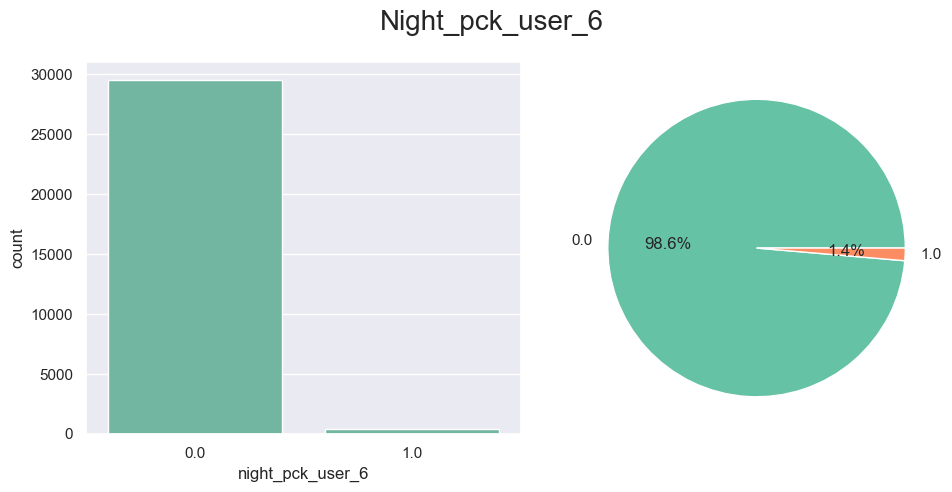

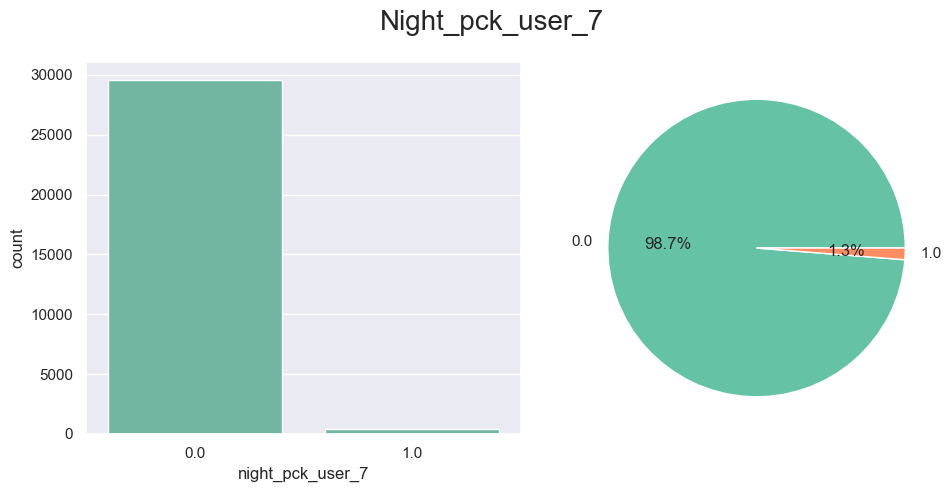

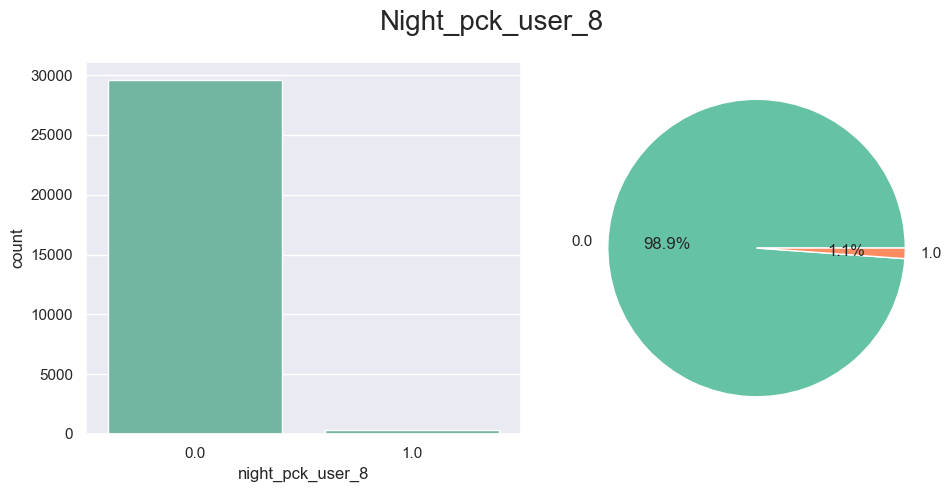

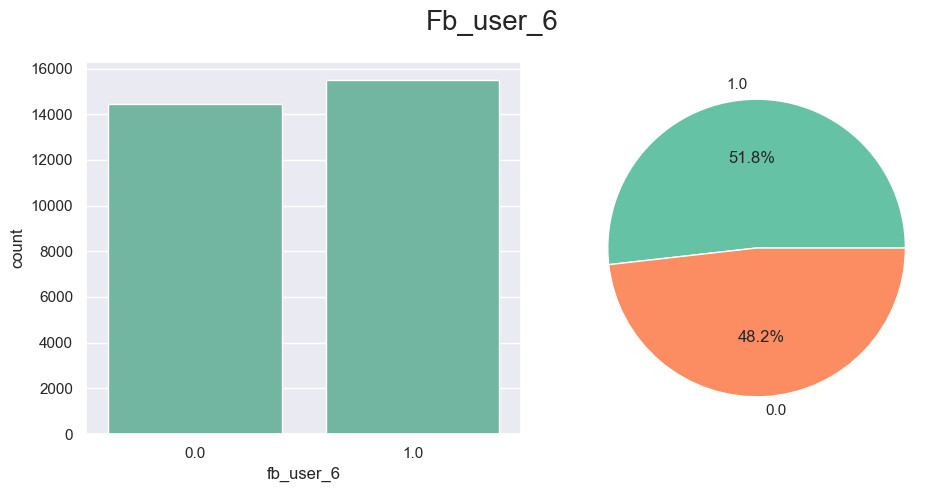

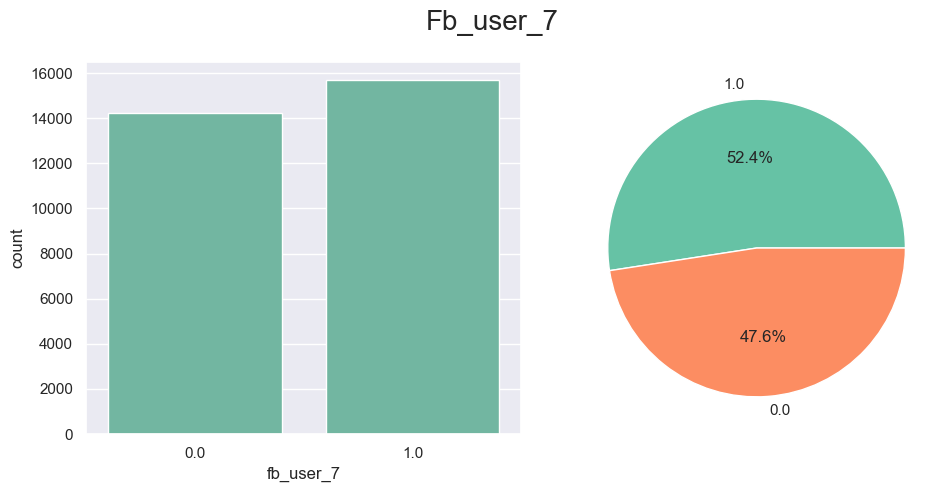

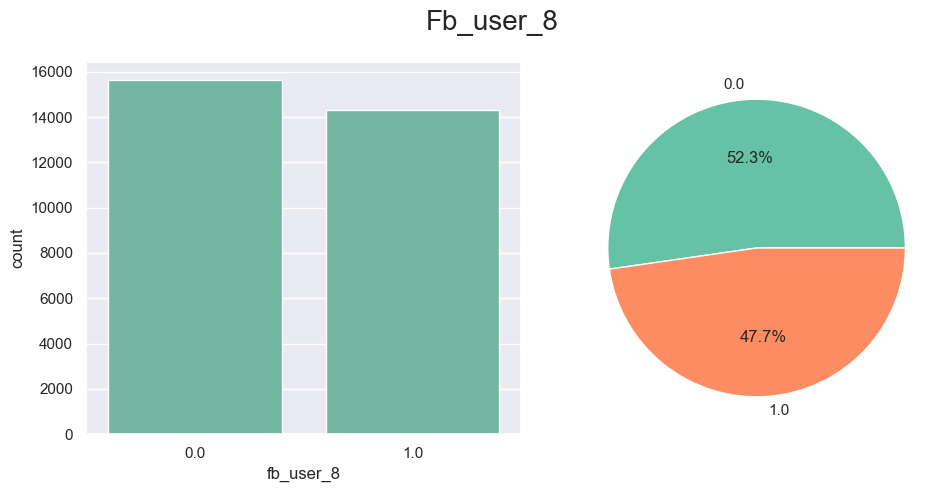

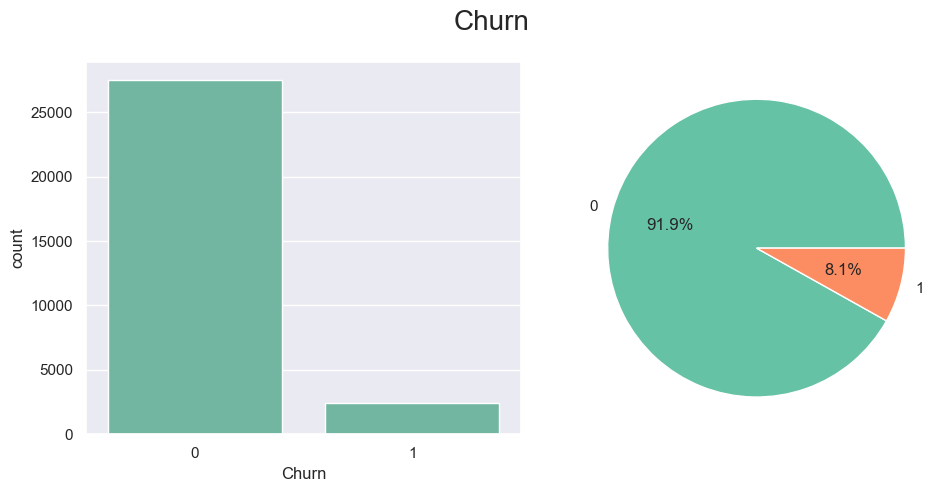

In [35]:
def uni_cat_cols(df, cat_cols):
    """
    Input : Dataframe and Categorical columns list
    Output: Displays univariate graphs of categorical columns
    """
    for col in cat_cols:
        fig, axes = plt.subplots(1, 2, figsize=(10,5))

        # Bargraphs for category distributions
        plt.subplot(1, 2, 1)
        sns.countplot(data=df, x=col, ax=axes[0])

        # Piecharts for category distributions
        plt.subplot(1, 2, 2)
        df[col].value_counts().plot.pie(ax=axes[1], autopct='%1.1f%%')
        plt.ylabel("")

        fig.suptitle(col.capitalize(), fontsize = 20)
        plt.tight_layout()

        plt.show()

uni_cat_cols(data_hvc, cat_cols)

Note that `night_pck_user_*` columns have very low variability, i.e., over 98% of the column in each month consists non-users of night packs than users, hence these can be dropped to avoid overfitting.

In [36]:
# Dropping Night Pack users columns
cols_to_drop = data_hvc.columns[data_hvc.columns.str.contains(('night_pck_user_'))]
print("We are dropping the following", len(cols_to_drop), "columns.\n")
display(cols_to_drop)
print("\nShape of the dataset before dropping columns:", data_hvc.shape)
data_hvc.drop(columns = cols_to_drop, inplace = True)
print("\nShape of the dataset after dropping columns:", data_hvc.shape)

We are dropping the following 3 columns.



Index(['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8'], dtype='object')


Shape of the dataset before dropping columns: (29953, 149)

Shape of the dataset after dropping columns: (29953, 146)


### Bivariate Analysis (With Target)

In [37]:
cat_cols = list(set(cat_cols)-set(cols_to_drop)-{'Churn'})

print("Overall percentage of churn is:", round(100*data_hvc[target].mean(),2),"%")

Overall percentage of churn is: 8.12 %


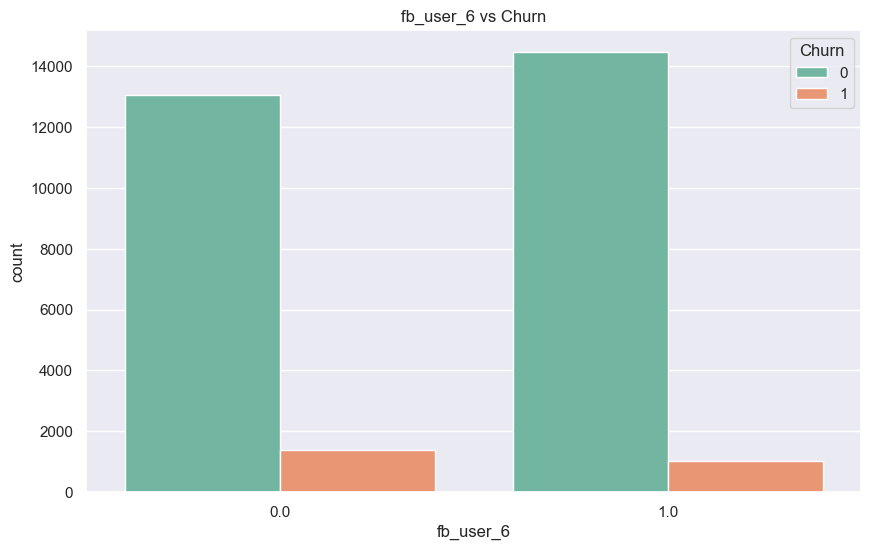

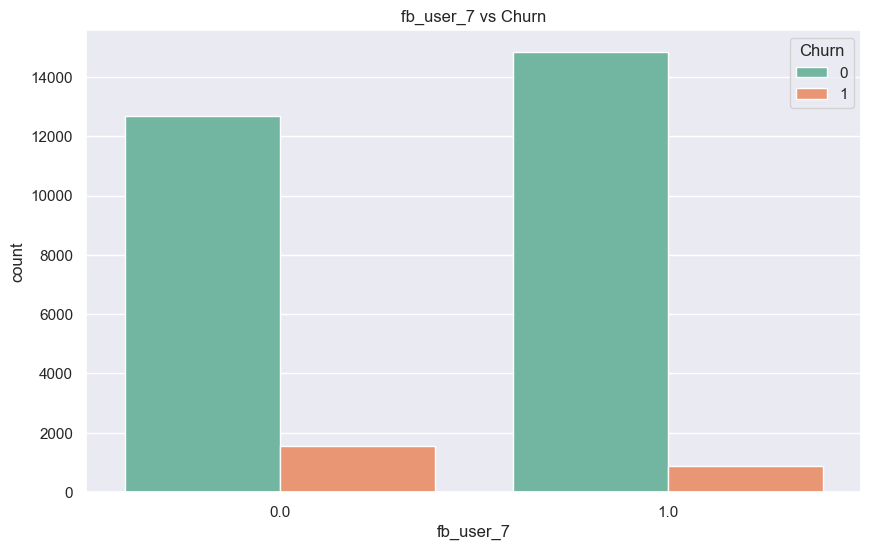

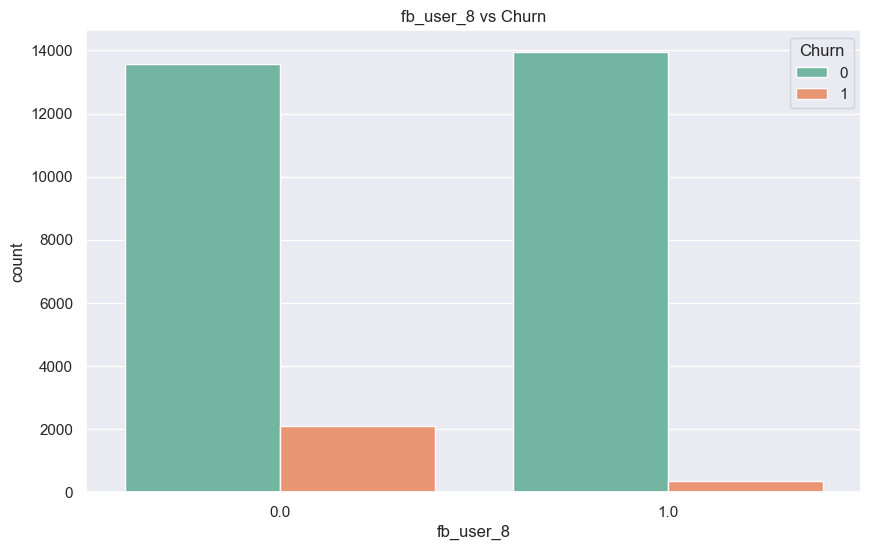

In [38]:
for col in cat_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue=target, data=data_hvc)
    plt.title(f'{col} vs {target}')
    unique_categories = data_hvc[col].unique()
    plt.show()
    print("\n")

**Observations:**
- There is data imbalance in the target column which was already observed and noted.
- The night pack columns don't have great variability within the column itself, hence they are dropped.
- fb_user columns don't show much difference in the churn behaviour except in August month. We still keep them and continue with the rest of our analysis.

## Numerical Variables Visualizations

There are 142 numerical columns, but our understanding of the data allows us to shortlist the important columns containing summaries to derive a representative of the data and analyse. We define a list containing the important columns and create visualization with hue as the target column to continue our analysis.

In [39]:
mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 
            'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']

rech_cols =['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 
            'total_rech_amt_data_6', 'total_rech_amt_data_7', 'total_rech_amt_data_8'] 

arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8', 
             'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 
             'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8',  
             'aon']

In [40]:
def num_pairplot_target(df, num_cols, target):
    """
    Given the dataframe and numeric column list,
    this function plots a pairplot using sns library.
    Input : Dataframe, numeric columns list, categorical target column
    Output: Displays the final pairplot
    """
    g = sns.pairplot(data=df[num_cols+[target]], diag_kind='kde' , hue = target)
    g.fig.suptitle("Pairplot between Numeric Variables with Target as hue", y=1.02)
    plt.show()

### Bivariate Visualizations with Target Variable as Hue

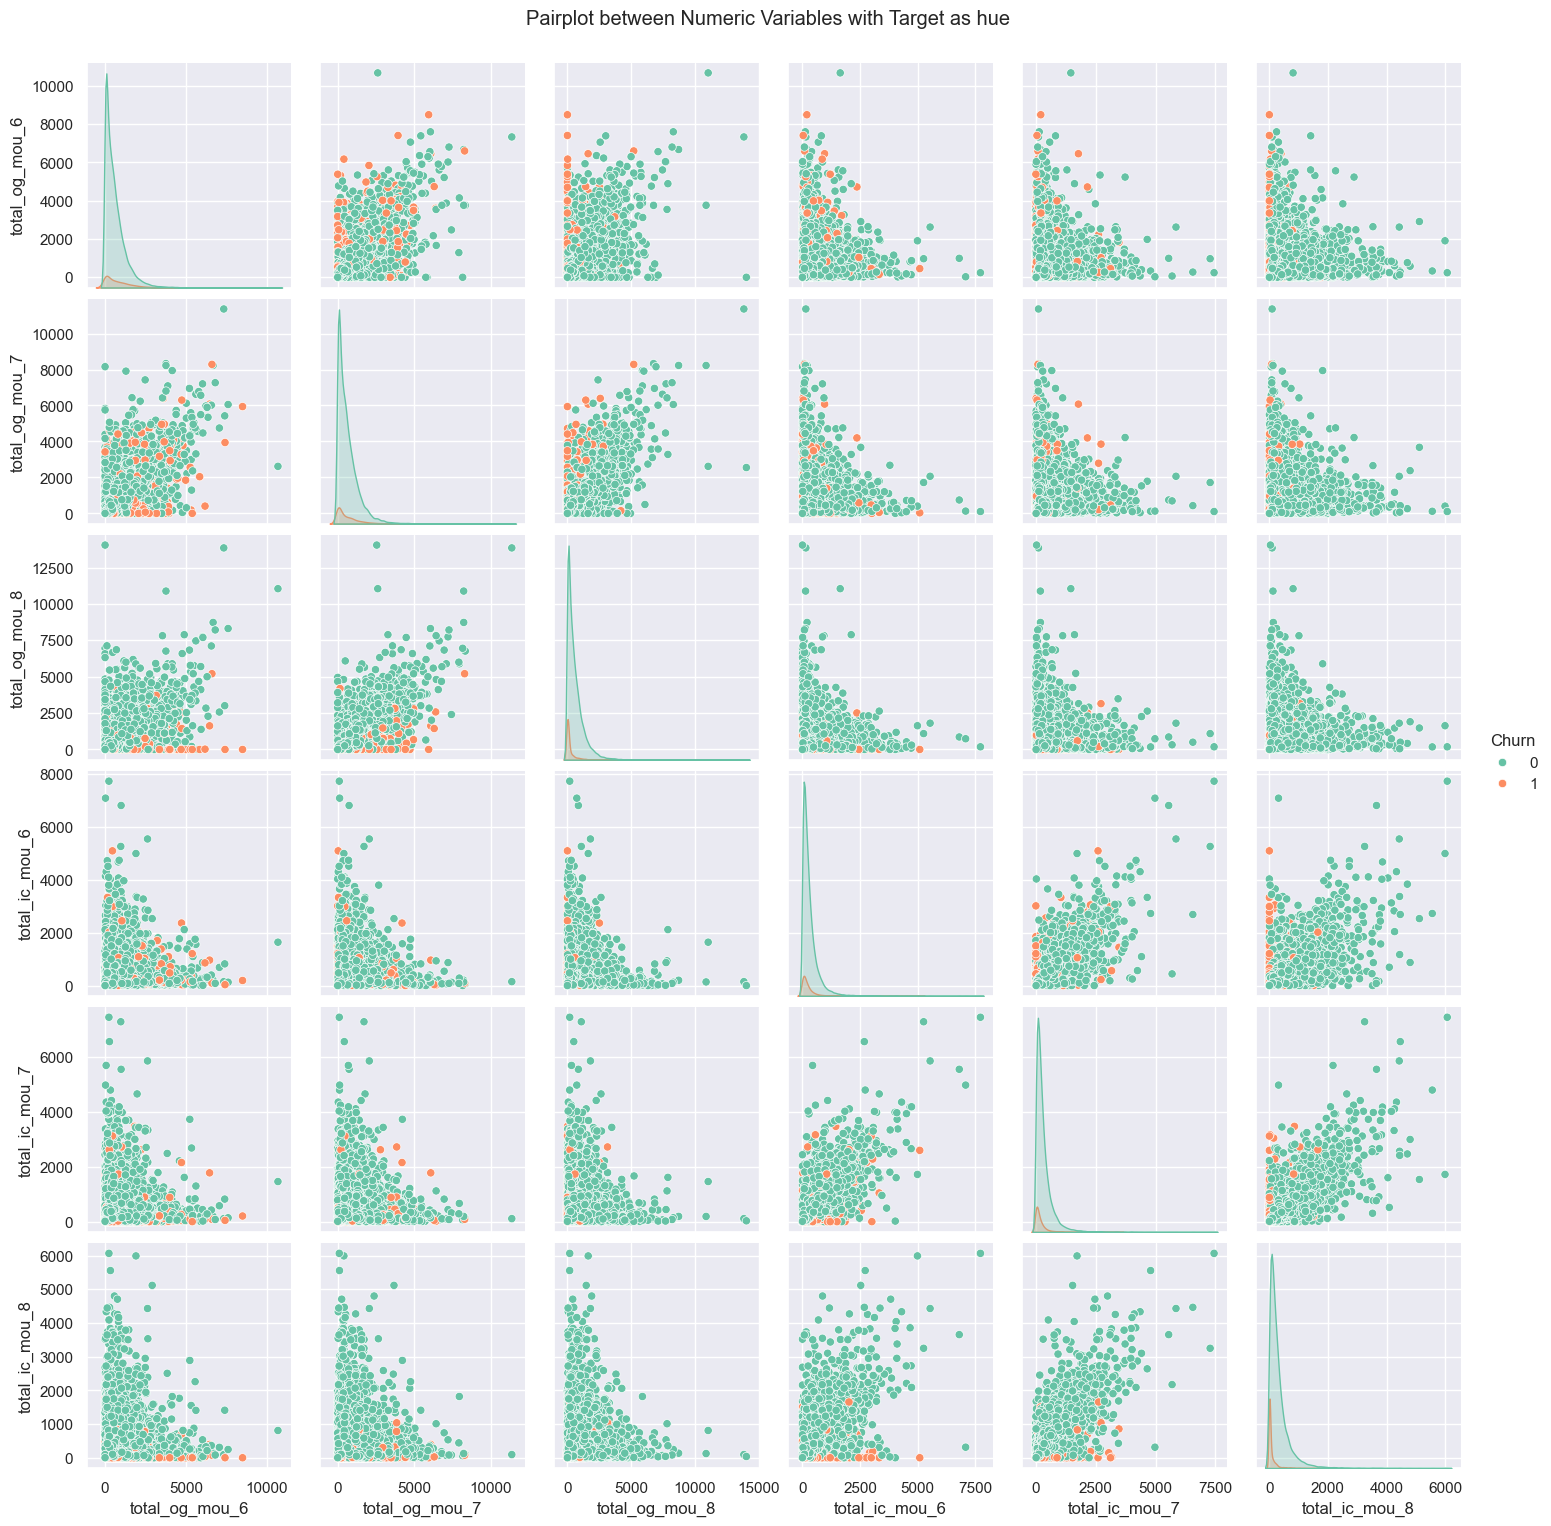

In [41]:
num_pairplot_target(data_hvc, mou_cols, target)

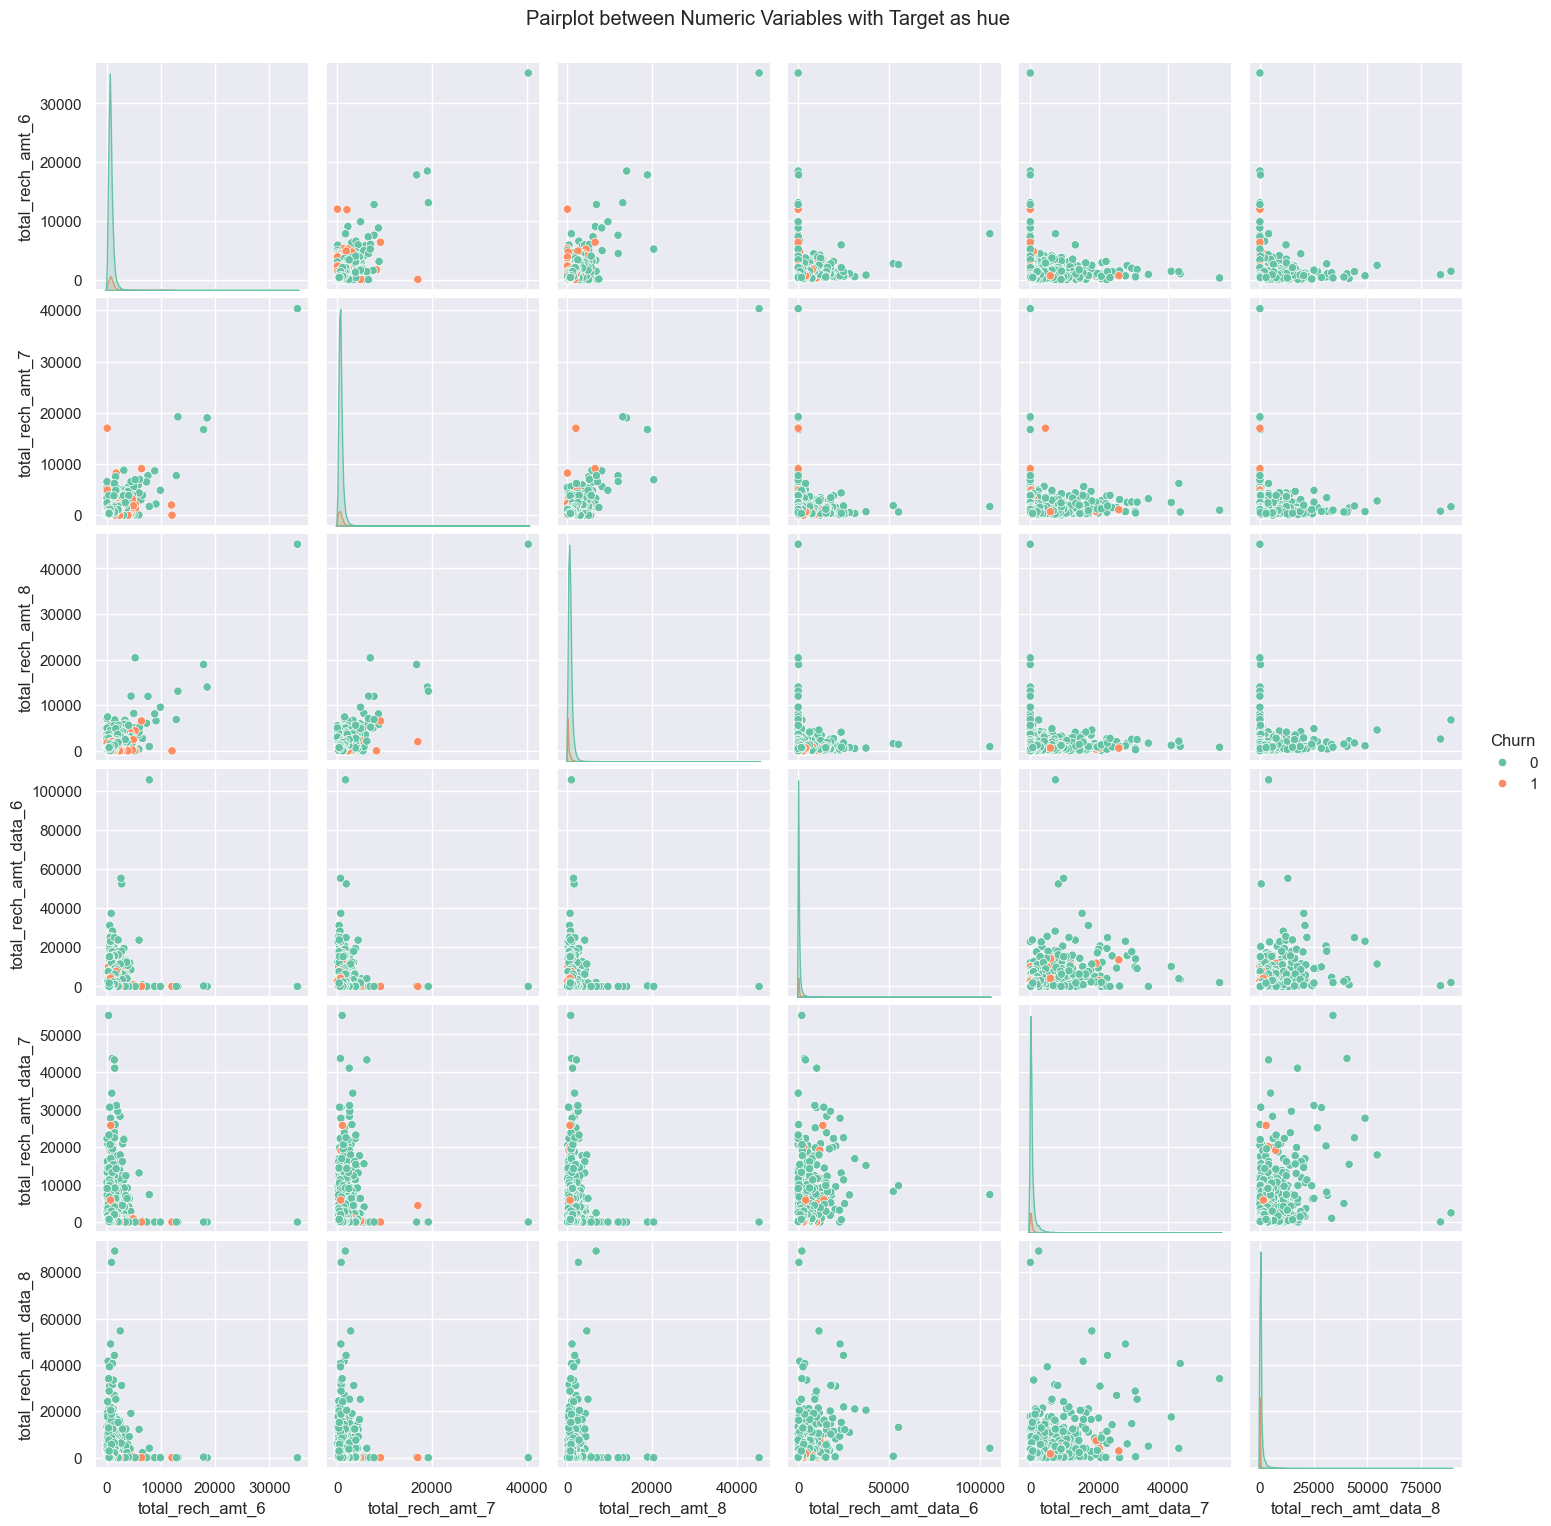

In [42]:
num_pairplot_target(data_hvc, rech_cols, target)

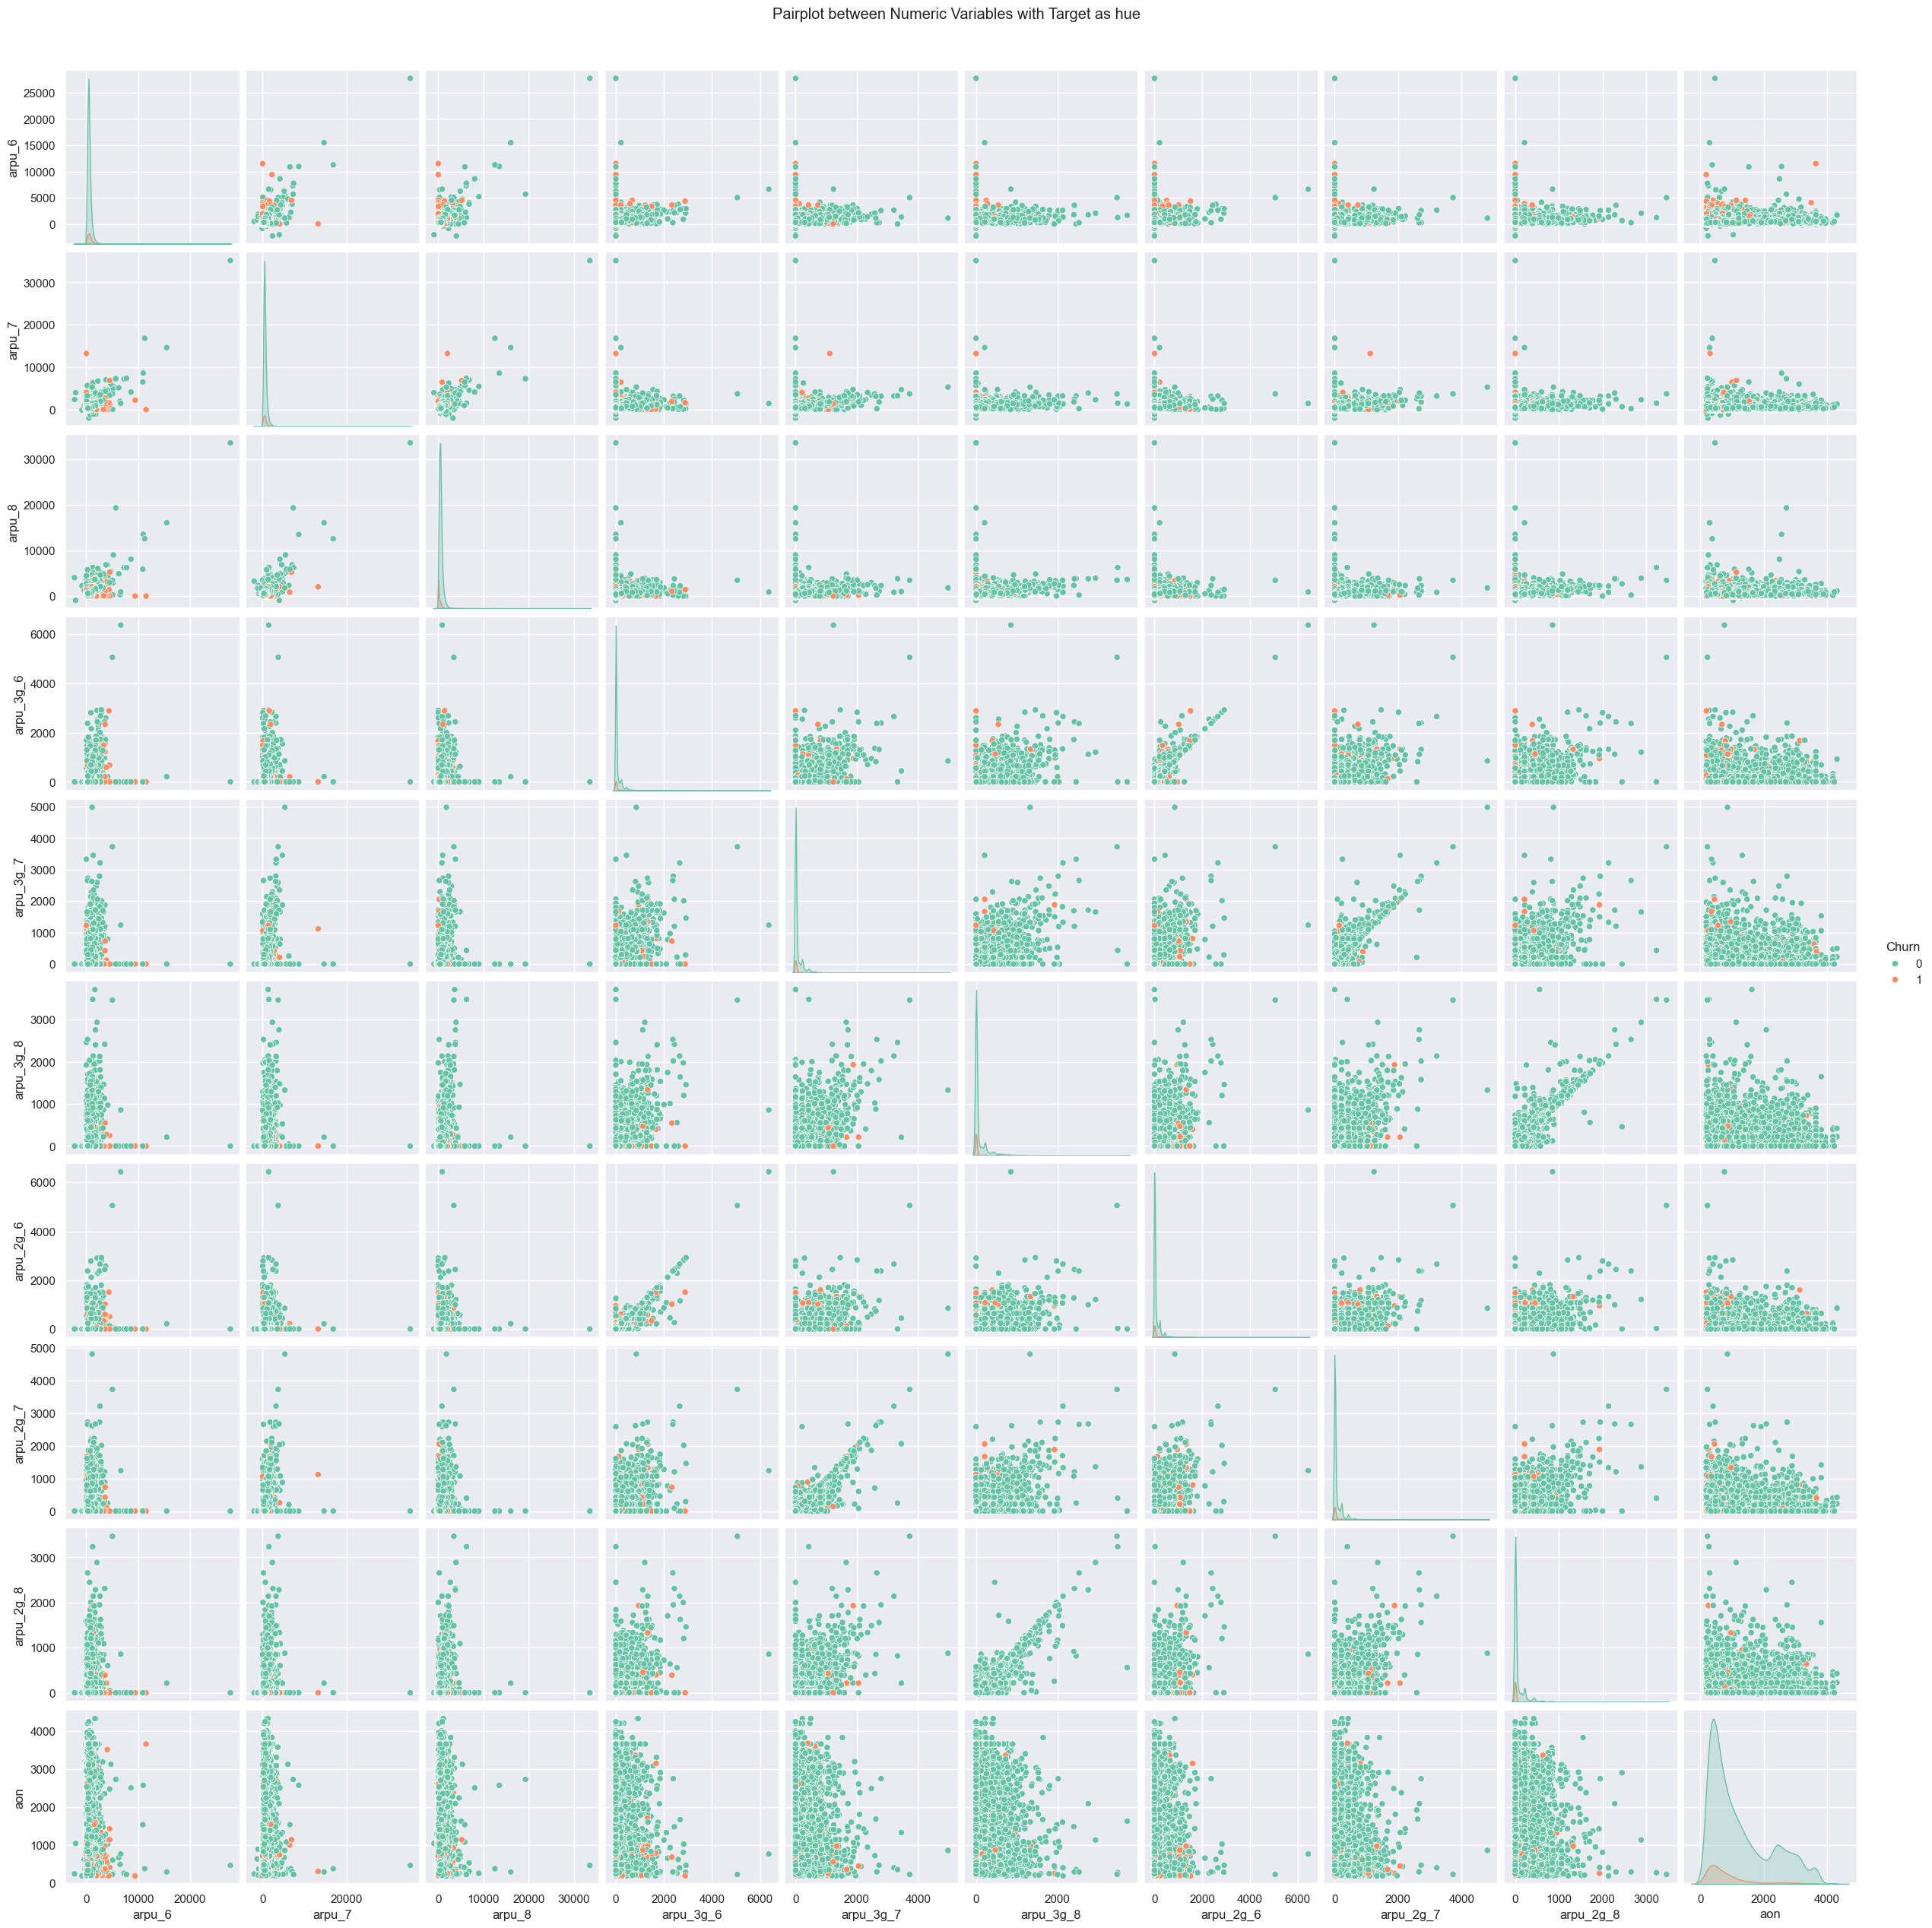

In [43]:
num_pairplot_target(data_hvc, arpu_cols, target)

**Observations:**
- Though there is data imbalance in the number of churners, we observe some visually seperable patterns in the scatter plots for churners and non-churners in various numeric columns.
- Since there are many numeric variables, it is difficult to identify and detail trends among themself. However, on average we observe a positive trend between most variables in the scatter plots.

### Multivariate Analysis

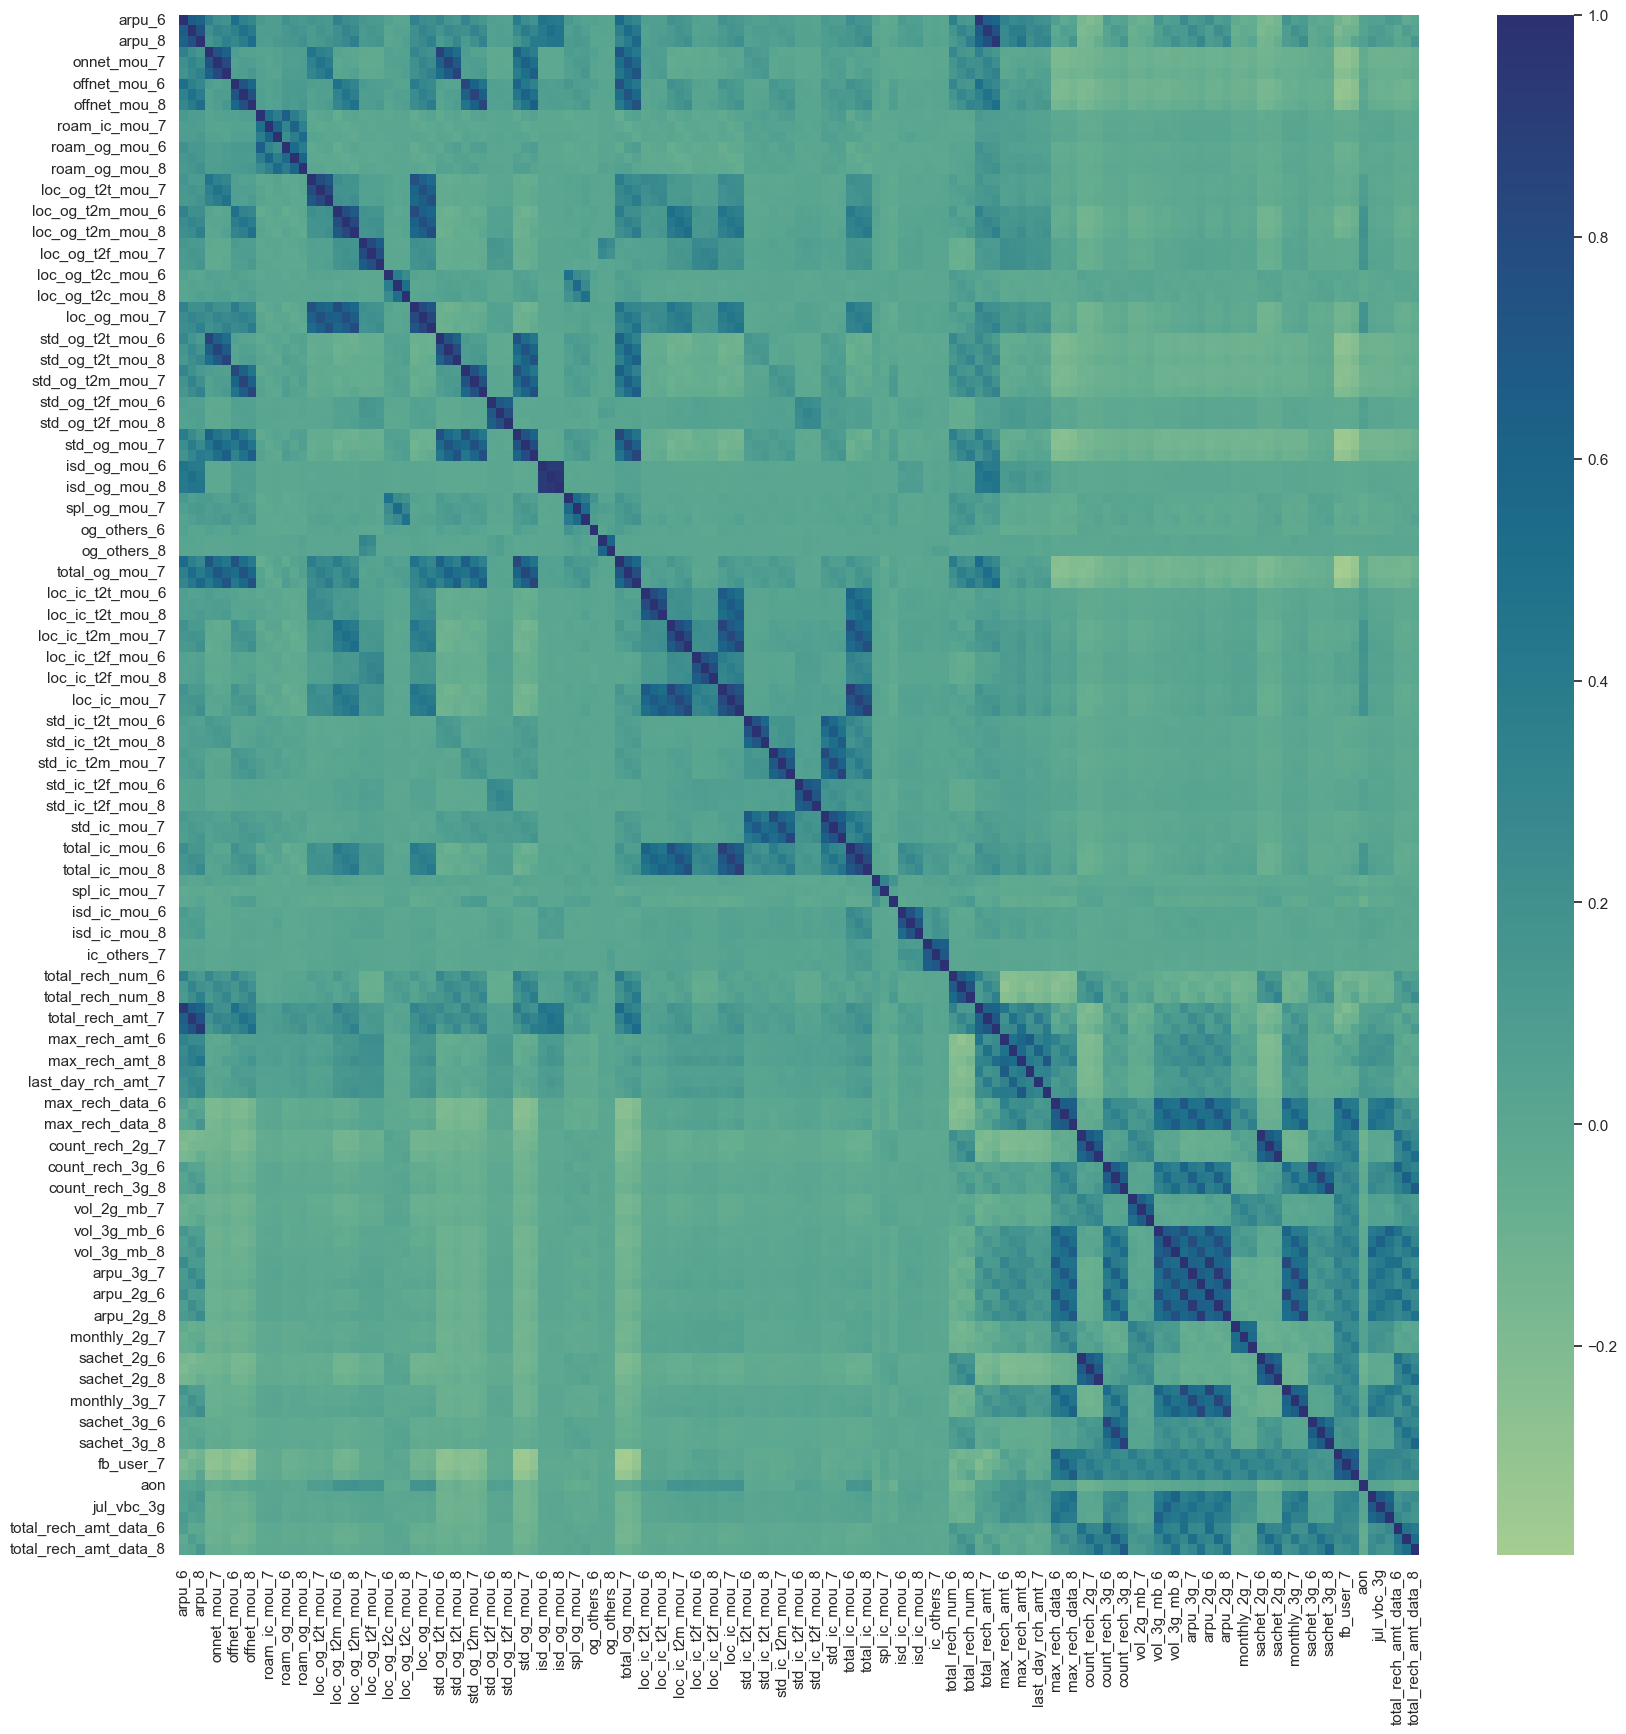

In [44]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,20))
sns.heatmap(data_hvc.drop('Churn', axis=1).corr(), cmap= 'crest')
plt.show()

**Observation:** In the above heatmap containing all the variables, we observe clusters of highly correlated features which indicates that multicollinearity will be an issue when we use linear models. 

We now get the top most highly correlated features.

In [45]:
# Finding top High correlated features
a = data_hvc.corr()
corr = a.where(np.triu(np.ones(a.shape), k=1).astype(bool))
corr = corr.unstack().dropna()
corr = pd.DataFrame(corr).reset_index()
corr.columns= ['Variable 1','Variable 2','Correlation']
corr['Absolute Correlation']= np.abs(corr['Correlation'])
display(corr.sort_values('Absolute Correlation', ascending= False).head(20))

Variable 1       Variable 2  Correlation  Absolute Correlation
8235       sachet_2g_8  count_rech_2g_8       0.9872                0.9872
8107       sachet_2g_7  count_rech_2g_7       0.9864                0.9864
7980       sachet_2g_6  count_rech_2g_6       0.9849                0.9849
4467  total_rech_amt_8           arpu_8       0.9553                0.9553
4278  total_rech_amt_6           arpu_6       0.9461                0.9461
4372  total_rech_amt_7           arpu_7       0.9436                0.9436
989       isd_og_mou_8     isd_og_mou_7       0.9431                0.9431
7257         arpu_2g_6        arpu_3g_6       0.9401                0.9401
7500         arpu_2g_8        arpu_3g_8       0.9377                0.9377
7378         arpu_2g_7        arpu_3g_7       0.9364                0.9364
988       isd_og_mou_8     isd_og_mou_6       0.9182                0.9182
945       isd_og_mou_7     isd_og_mou_6       0.9152                0.9152
3066    total_ic_mou_6     loc_ic_mou_6       0.8964                0.8964
3225    total_ic_mou_8     loc_ic_mou_8       0.8962                0.8962
3145    total_ic_mou_7     loc_ic_mou_7       0.8844                0.8844
9021       sachet_3g_8  count_rech_3g_8       0.8753                0.8753
501   std_og_t2t_mou_8      onnet_mou_8       0.8606                0.8606
469   std_og_t2t_mou_7      onnet_mou_7       0.8603                0.8603
438   std_og_t2t_mou_6      onnet_mou_6       0.8593                0.8593
8887       sachet_3g_7  count_rech_3g_7       0.8580                0.8580

With this analysis, we have a fairly decent idea of the dataset. We can now proceed with data preparation steps for modelling and the actual modelling of data to get our desired predicting model.

# Data Prepration for Modelling

## Train-Test split

We first split the data into training and testing sets so that we can properly evaluate any model we build on unseen data to give us an idea of model performance. This is the very first step so as to avoid any form of information leakage.

In [46]:
# Peforming the train test split 
data_hvc_train,data_hvc_test = train_test_split(data_hvc,train_size=0.7, test_size=0.3,random_state=100)

In [47]:
# Checking shape of train and test data
print(f"Train data shape:{data_hvc_train.shape}")
print(f"Test data shape:{data_hvc_test.shape}")

Train data shape:(20967, 146)
Test data shape:(8986, 146)


In [48]:
# Defining X_train an Y_train
y_train = data_hvc_train.pop("Churn")
X_train = data_hvc_train

In [49]:
# Defining X_test an Y_test
y_test = data_hvc_test.pop("Churn")
X_test = data_hvc_test

## Scaling/Standardization

We use z-standardization to scale all the features since data preprocessing is an important step before modelling, and especially before implementing PCA. PCA assumes that all the features have equal variance since it uses the decomposition of the variance-covariance matrix, hence we prefer using Standardization and not Normalization (`MinMaxScaler`).

(20967, 145)


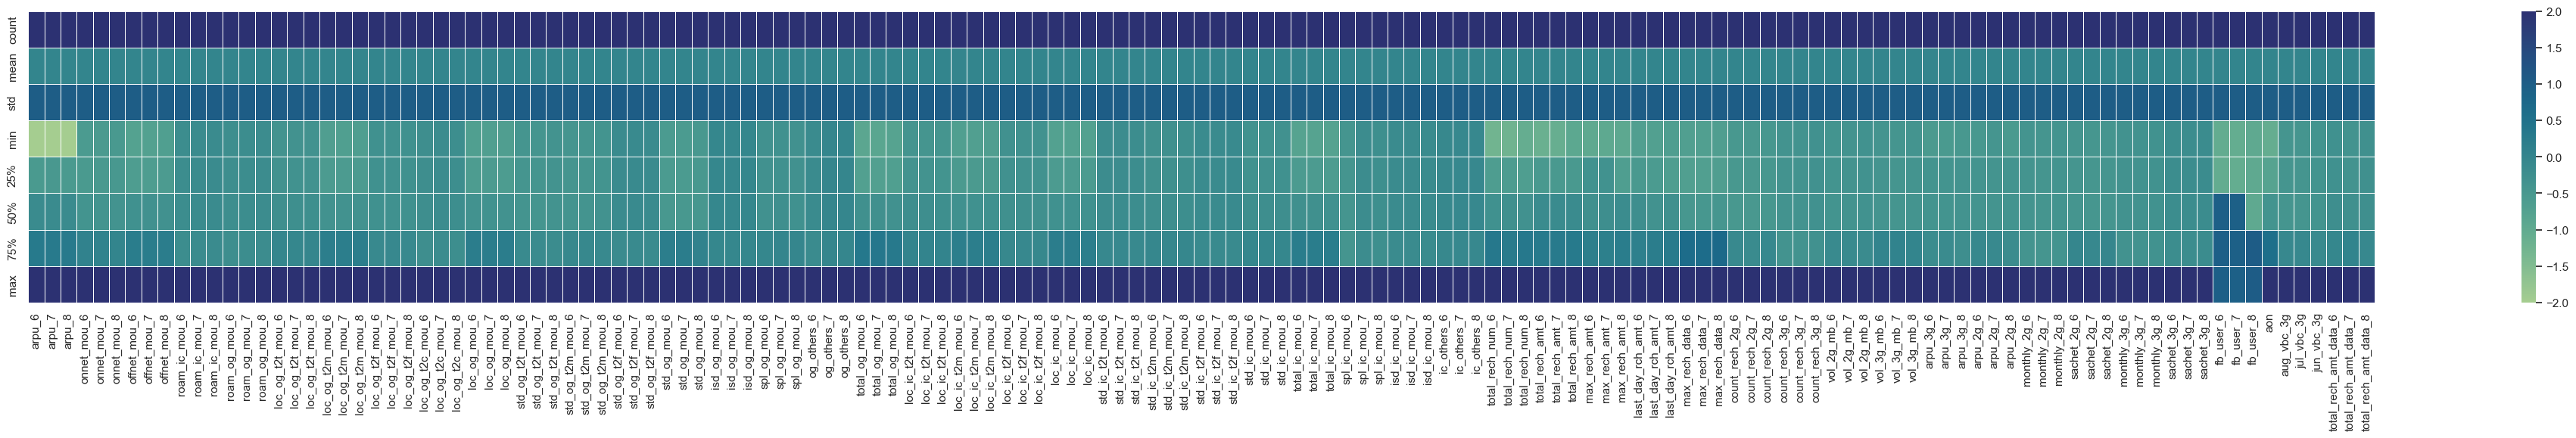

In [50]:
# Importing library and performing scaling
scale = StandardScaler()
temp_x_train = scale.fit_transform(X_train)

#Form the dataframe after scaling
X_train_scale = pd.DataFrame(temp_x_train,columns=X_train.columns)
# Check the shape of scaled data
print(X_train_scale.shape)

# Scaled Data visualized using a heatmap
plt.figure(figsize = (50,5))
sns.heatmap(X_train_scale.describe(), cmap= 'crest', vmin=-2, vmax=2, linewidths=0.5)
plt.show()

We used the colour variations to vary from values of -2 to 2 so that we can observe the mean and standard deviation which should be 0 and 1 respectively since we used a standard scaler. Extreme values get capped to let us observe the variation in colors easily. 

We can see that the standardization has been successfully performed since the mean and standard deviation values are 0 and 1 respectviely which can be visually confirmed from the heatmap.

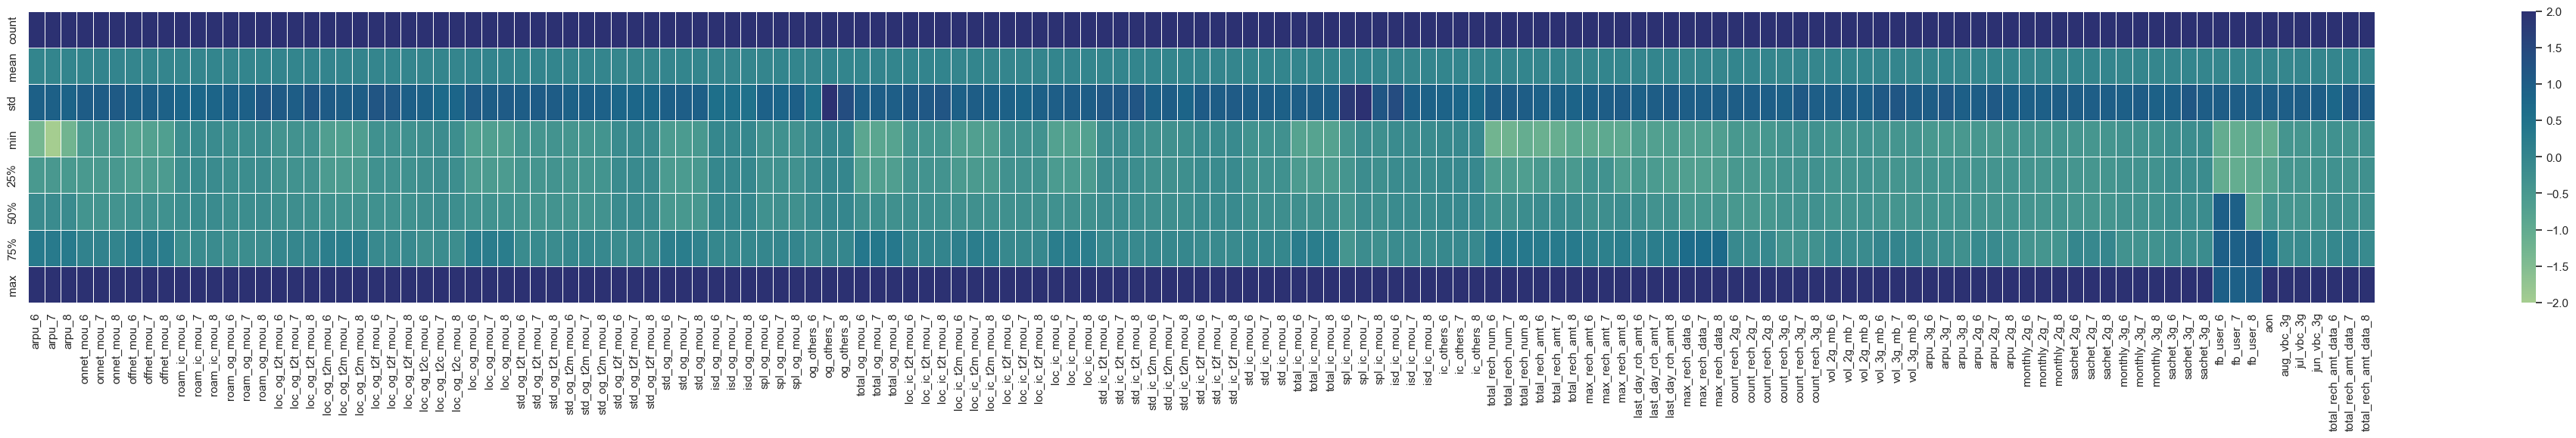

In [51]:
# Performing scaling on test set
temp_x_test = scale.transform(X_test)

# form the test set dataframe after scaling
X_test_scale = pd.DataFrame(temp_x_test,columns=X_test.columns)

# Scaled Data visualized using a heatmap
plt.figure(figsize = (50,5))
sns.heatmap(X_test_scale.describe(), cmap= 'crest', vmin=-2, vmax=2, linewidths=0.5)
plt.show()

Here we observe variations in the colours of the heatmap for the mean and standard deviation rows. This is because we only transform the test set and not fit it to the test set. 

## Building First Model

In this section we build our very first model which will be trained on all the features. It will be the yard stick to evaluate the performance of various techniques and models we will later build.

In [52]:
# Building logistic regression
lreg = LogisticRegression(max_iter=1000)
lreg.fit(X_train_scale, y_train)

LogisticRegression(max_iter=1000)

In [53]:
# Making prediction
y_pred = lreg.predict(X_test_scale)

# Evaluating the model
print ('Accuracy: ', accuracy_score(y_test, y_pred))
print ('F1 score: ', f1_score(y_test, y_pred))
print ('Recall: ', recall_score(y_test, y_pred))
print ('Precision: ', precision_score(y_test, y_pred))
print ('\nClasification Report:\n', classification_report(y_test,y_pred))
print ('\nConfussion Matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy:  0.9348987313598932
F1 score:  0.417910447761194
Recall:  0.30837004405286345
Precision:  0.6481481481481481

Clasification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      8305
           1       0.65      0.31      0.42       681

    accuracy                           0.93      8986
   macro avg       0.80      0.65      0.69      8986
weighted avg       0.92      0.93      0.92      8986


Confussion Matrix:
 [[8191  114]
 [ 471  210]]


**The above basic logistic regression model is having very low values of recall and precision.**

We observe that the accuracy of the obtained model is good but the recall value is very low implying that the model is unable to properly classify the minority class. The same can be seen in the Confusion matrix as well. Hence this requires us to check for and handle the class imbalance appropriately.

## Treating Data Imbalance

In [54]:
## Checking data for Imbalance
df_hvc_churn=round((len(data_hvc[data_hvc["Churn"]==1])/(data_hvc.shape[0])*100),2)
print(f"Percentage of customers tagged as Churn: {df_hvc_churn}")
df_hvc_churn=round((len(data_hvc[data_hvc["Churn"]==0])/(data_hvc.shape[0])*100),2)
print(f"Percentage of customers tagged as No-Churn: {df_hvc_churn}")

Percentage of customers tagged as Churn: 8.12
Percentage of customers tagged as No-Churn: 91.88


**Above data is imbalanced and we need to handle this.** We try different data imbalance handling techniques and choose whichever is giving best performance in predicting the minority class with our basic model.

### Random Undersampling

In [55]:
# Random Undersampling
under_sample = RandomUnderSampler(random_state = 5)
X_resampled_us, y_resampled_us = under_sample.fit_resample(X_train_scale, y_train)

print(sorted(Counter(y_resampled_us).items()))

[(0, 1752), (1, 1752)]


In [56]:
# Building basic model of undersampled data
lreg_us = LogisticRegression(max_iter=1000)
lreg_us.fit(X_resampled_us, y_resampled_us)

y_pred_us = lreg_us.predict(X_test_scale)

In [57]:
# Evaluating the model build using undersampled data
print ('Accuracy: ', accuracy_score(y_test, y_pred_us))
print ('F1 score: ', f1_score(y_test, y_pred_us))
print ('Recall: ', recall_score(y_test, y_pred_us))
print ('Precision: ', precision_score(y_test, y_pred_us))
print ('\nClasification Report:\n', classification_report(y_test,y_pred_us))
print ('\nConfussion Catrix:\n',confusion_matrix(y_test, y_pred_us))

Accuracy:  0.7956821722679724
F1 score:  0.38759172781854573
Recall:  0.8531571218795888
Precision:  0.25075528700906347

Clasification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88      8305
           1       0.25      0.85      0.39       681

    accuracy                           0.80      8986
   macro avg       0.62      0.82      0.63      8986
weighted avg       0.93      0.80      0.84      8986


Confussion Catrix:
 [[6569 1736]
 [ 100  581]]


### TOMEK Links

In [58]:
# Tomek Links
tomek_sample = TomekLinks(sampling_strategy='majority')
X_resampled_tomek, y_resampled_tomek = tomek_sample.fit_resample(X_train_scale, y_train)
print(sorted(Counter(y_resampled_tomek).items()))

[(0, 18979), (1, 1752)]


In [59]:
# Building basic model of undersampled data
lreg_tomek = LogisticRegression(max_iter=1000)
lreg_tomek.fit(X_resampled_tomek, y_resampled_tomek)

y_pred_tomek = lreg_us.predict(X_test_scale)

In [60]:
# Evaluating the model build using undersampled data
print ('Accuracy: ', accuracy_score(y_test, y_pred_tomek))
print ('F1 score: ', f1_score(y_test, y_pred_tomek))
print ('Recall: ', recall_score(y_test, y_pred_tomek))
print ('Precision: ', precision_score(y_test, y_pred_tomek))
print ('\nClasification Report:\n', classification_report(y_test,y_pred_tomek))
print ('\nConfussion Matrix:\n',confusion_matrix(y_test, y_pred_tomek))

Accuracy:  0.7956821722679724
F1 score:  0.38759172781854573
Recall:  0.8531571218795888
Precision:  0.25075528700906347

Clasification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88      8305
           1       0.25      0.85      0.39       681

    accuracy                           0.80      8986
   macro avg       0.62      0.82      0.63      8986
weighted avg       0.93      0.80      0.84      8986


Confussion Matrix:
 [[6569 1736]
 [ 100  581]]


**Clearly tomek links is not providing balanced data**

### Random Oversampling

In [61]:
# Random OverSampling
over_sample = RandomOverSampler(sampling_strategy = 1)
X_resampled_os, y_resampled_os = over_sample.fit_resample(X_train_scale, y_train)
print(sorted(Counter(y_resampled_os).items()))

[(0, 19215), (1, 19215)]


In [62]:
# Building basic model using randomly oversampled data
lreg_os = LogisticRegression(max_iter=1000)
lreg_os.fit(X_resampled_os, y_resampled_os)

y_pred_os = lreg_os.predict(X_test_scale)

In [63]:
# Evaluating the above model
print ('Accuracy: ', accuracy_score(y_test, y_pred_os))
print ('F1 score: ', f1_score(y_test, y_pred_os))
print ('Recall: ', recall_score(y_test, y_pred_os))
print ('Precision: ', precision_score(y_test, y_pred_os))
print ('\nClasification Report:\n', classification_report(y_test,y_pred_os))
print ('\nConfussion Matrix:\n',confusion_matrix(y_test, y_pred_os))

Accuracy:  0.8072557311373247
F1 score:  0.4002770083102493
Recall:  0.8487518355359766
Precision:  0.26189397371998185

Clasification Report:
               precision    recall  f1-score   support

           0       0.98      0.80      0.89      8305
           1       0.26      0.85      0.40       681

    accuracy                           0.81      8986
   macro avg       0.62      0.83      0.64      8986
weighted avg       0.93      0.81      0.85      8986


Confussion Matrix:
 [[6676 1629]
 [ 103  578]]


### SMOTE

In [64]:
## SMOTE
smt = SMOTE(random_state=100, k_neighbors=5)
X_resampled_smt, y_resampled_smt = smt.fit_resample(X_train_scale, y_train)
print(sorted(Counter(y_resampled_smt).items()))

[(0, 19215), (1, 19215)]


In [65]:
# Building logistic model with SMOTE data
lreg_smt = LogisticRegression(max_iter=1000)
lreg_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_smt = lreg_smt.predict(X_test_scale)

In [66]:
# Evaluating the above model
print ('Accuracy: ', accuracy_score(y_test, y_pred_smt))
print ('F1 score: ', f1_score(y_test, y_pred_smt))
print ('Recall: ', recall_score(y_test, y_pred_smt))
print ('Precision: ', precision_score(y_test, y_pred_smt))
print ('\nClasification Report:\n', classification_report(y_test,y_pred_smt))
print ('\nConfussion Matrix:\n',confusion_matrix(y_test, y_pred_smt))

Accuracy:  0.8211662586245271
F1 score:  0.41414509660955157
Recall:  0.8340675477239354
Precision:  0.2754607177497575

Clasification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      8305
           1       0.28      0.83      0.41       681

    accuracy                           0.82      8986
   macro avg       0.63      0.83      0.65      8986
weighted avg       0.93      0.82      0.86      8986


Confussion Matrix:
 [[6811 1494]
 [ 113  568]]


### ADASYN

In [67]:
# Performing ADASYN
ada = ADASYN(random_state=45, n_neighbors=5)
X_resampled_ada, y_resampled_ada = ada.fit_resample(X_train_scale, y_train)
print(sorted(Counter(y_resampled_ada).items()))

[(0, 19215), (1, 19348)]


In [68]:
# Building logistic model using ADASYN data
lreg_ada = LogisticRegression(max_iter=1000)
lreg_ada.fit(X_resampled_ada, y_resampled_ada)

y_pred_ada = lreg_ada.predict(X_test_scale)

In [69]:
# Evaluating above model
print ('Accuracy: ', accuracy_score(y_test, y_pred_ada))
print ('F1 score: ', f1_score(y_test, y_pred_ada))
print ('Recall: ', recall_score(y_test, y_pred_ada))
print ('Precision: ', precision_score(y_test, y_pred_ada))
print ('\nClasification Report:\n', classification_report(y_test,y_pred_ada))
print ('\nConfussion Matrix:\n',confusion_matrix(y_test, y_pred_ada))

Accuracy:  0.7959047407077676
F1 score:  0.38988689288090483
Recall:  0.8604992657856094
Precision:  0.25204301075268815

Clasification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88      8305
           1       0.25      0.86      0.39       681

    accuracy                           0.80      8986
   macro avg       0.62      0.83      0.63      8986
weighted avg       0.93      0.80      0.84      8986


Confussion Matrix:
 [[6566 1739]
 [  95  586]]


### SMOTE+TOMEK

In [70]:
# SMOTE+TOMEK
smt_tmk = SMOTETomek(random_state=45)
X_resampled_smt_tmk, y_resampled_smt_tmk = smt_tmk.fit_resample(X_train_scale, y_train)
print(sorted(Counter(y_resampled_smt_tmk).items()))

[(0, 19207), (1, 19207)]


In [71]:
# Building logistic model using SMOTE+TOMEK data
lreg_smt_tmk = LogisticRegression(max_iter=1000)
lreg_smt_tmk.fit(X_resampled_smt_tmk, y_resampled_smt_tmk)

y_pred_smt_tmk = lreg_smt_tmk.predict(X_test_scale)

In [72]:
# Evaluating above model
print ('Accuracy: ', accuracy_score(y_test, y_pred_smt_tmk))
print ('F1 score: ', f1_score(y_test, y_pred_smt_tmk))
print ('Recall: ', recall_score(y_test, y_pred_smt_tmk))
print ('Precision: ', precision_score(y_test, y_pred_smt_tmk))
print ('\nClasification Report:\n', classification_report(y_test,y_pred_smt_tmk))
print ('\nConfussion Matrix:\n',confusion_matrix(y_test, y_pred_smt_tmk))

Accuracy:  0.8196082795459604
F1 score:  0.4116152450090744
Recall:  0.8325991189427313
Precision:  0.2733847637415622

Clasification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      8305
           1       0.27      0.83      0.41       681

    accuracy                           0.82      8986
   macro avg       0.63      0.83      0.65      8986
weighted avg       0.93      0.82      0.86      8986


Confussion Matrix:
 [[6798 1507]
 [ 114  567]]


In [73]:
# Define the sampling techniques
sampling_techniques = ['Random Undersampling', 'Random Oversampling','TOMEK','SMOTE','ADASYN','SMOTE+TOMEK']
predictions = [y_pred_us, y_pred_os, y_pred_tomek, y_pred_smt, y_pred_ada, y_pred_smt_tmk]
# Create a table to store the results
results_table = []

for i, pred in enumerate(predictions):
    results = {
        'Sampling Technique': sampling_techniques[i],
        'Accuracy': accuracy_score(y_test, pred),
        'F1 Score': f1_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
    }
    results_table.append(results)

# Print the table
print("\nEvaluation Metrics for Different Sampling Techniques:\n")
print("{:<20} {:<10} {:<10} {:<10} {:<10}".format('Sampling Technique', 'Accuracy', 'F1 Score', 'Recall', 'Precision'))
for result in results_table:
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(result['Sampling Technique'], result['Accuracy'], result['F1 Score'], result['Recall'], result['Precision']))


Evaluation Metrics for Different Sampling Techniques:

Sampling Technique   Accuracy   F1 Score   Recall     Precision 
Random Undersampling 0.7957     0.3876     0.8532     0.2508    
Random Oversampling  0.8073     0.4003     0.8488     0.2619    
TOMEK                0.7957     0.3876     0.8532     0.2508    
SMOTE                0.8212     0.4141     0.8341     0.2755    
ADASYN               0.7959     0.3899     0.8605     0.2520    
SMOTE+TOMEK          0.8196     0.4116     0.8326     0.2734    


For the problem statement of predicting customer churn, False negatives i.e. wrongfully predicting customers who would have churned as no churn would be a bigger concern for the business than False possitives i.e. wrongfully predicting no churn customers as churn. Hence, "Recall" is most important metric based on our business understanding. **We select ADASYN resampling technique for dealing with data imbalance because it is gving the best Recall.**  

# Feature Engineering - PCA

In [74]:
# PCA
pca_churn = PCA(random_state=100)
pca_churn.fit(X_resampled_ada)

PCA(random_state=100)

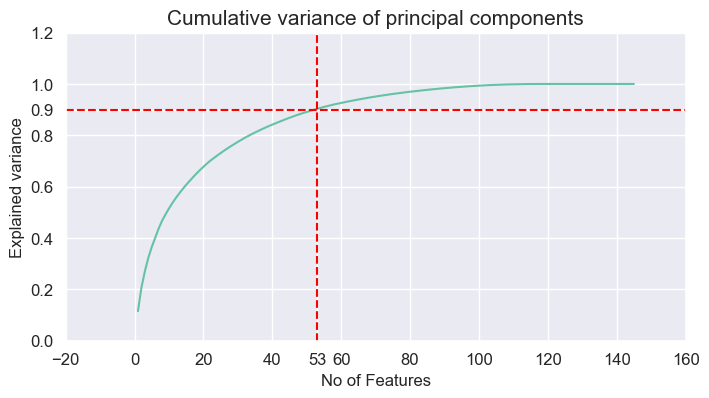

In [75]:
# Cumulaltive sum of explained variance
var_cumu = np.cumsum(pca_churn.explained_variance_ratio_)
# Find the index where cumulative explained variance crosses 90%
index_90_percent = np.argmax(var_cumu >= 0.9)

# Plotting Cumulative Explained Variance : SCREE Plot
plt.figure(figsize=[8,4])
plt.plot(range(1,len(var_cumu)+1), var_cumu)

plt.axhline(y=0.9, color='red', linestyle='--', label='Constant Line at y=0.9')
plt.axvline(x=index_90_percent + 1, color='red', linestyle='--', label='Intersection at 90%')
# Set ticks at the intersection point
existing_xticks = plt.xticks()[0]
existing_yticks = plt.yticks()[0]
new_xticks = list(existing_xticks) + [index_90_percent + 1]
new_yticks = list(existing_yticks) + [0.9]
plt.xticks(new_xticks)
plt.yticks(new_yticks)

plt.title("Cumulative variance of principal components",size=15)
plt.ylabel("Explained variance",size=12)
plt.xlabel("No of Features",size=12)
plt.tick_params(size=5,labelsize = 12) # Tick size in both X and Y axes
plt.grid(0.3)

In [76]:
# Obtaining PCs by choosing the amount of variance to be explained.
pca_demo = PCA(0.90,random_state=100)
X_train_pca1 = pca_demo.fit_transform(X_resampled_ada)
print(f"Number of principal components required to explain 90% of the variance: {X_train_pca1.shape[1]}")

Number of principal components required to explain 90% of the variance: 53


In [77]:
# Iniating PCA with 53 componenets
pca_final = IncrementalPCA(n_components=53)
df_train_pca = pca_final.fit_transform(X_resampled_ada)
print(df_train_pca.shape)

(38563, 53)


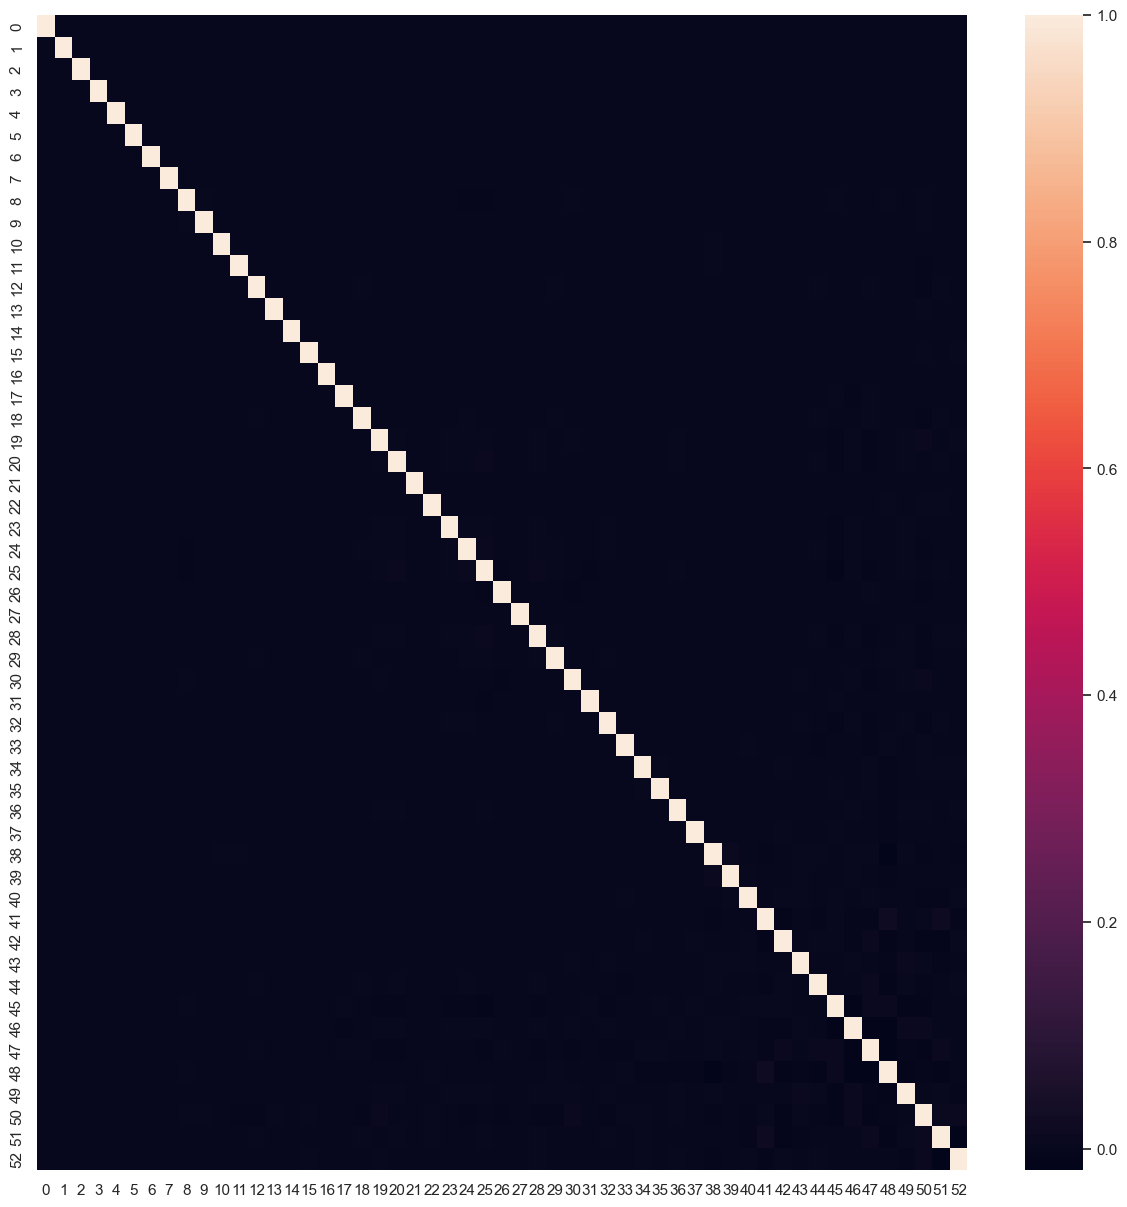

In [78]:
corrmat = np.corrcoef(df_train_pca.transpose())

plt.figure(figsize=[15, 15])

# Create a heatmap without annotations
sns.heatmap(corrmat, annot=False)

plt.show()

In [79]:
# Applying transformation on Test set
df_test_pca = pca_final.transform(X_test_scale)
print("X test shape after applying transformation:", df_test_pca.shape)

X test shape after applying transformation: (8986, 53)


# Model building for Predictions

Creating functions that will evaluate model performances given the predictions as inputs. We will be using these multiple times, hence defining a function is ideal.

In [80]:
# Function definition to check the performance of a model on train data
def calculate_performance_traindata(model_name, y_train, y_train_pred, train_pred_prob):
    '''
    model_name: Name of the model for identification
    y_train: True labels for the training set
    y_train_pred: Predicted labels for the training set
    train_pred_prob: Predicted probabilities for the training set
    '''
    
    print(f"{model_name} (Train Data):\n")
    
    # Calculate and print precision
    precision = metrics.precision_score(y_train, y_train_pred)
    print(f"Precision: {precision:.4f}")
    
    # Calculate and print recall
    recall = metrics.recall_score(y_train, y_train_pred)
    print(f"Recall: {recall:.4f}")
    
    # Calculate and print F1 score
    f1_score = metrics.f1_score(y_train, y_train_pred)
    print(f"F1 Score: {f1_score:.4f}")
    
    # Calculate and print ROC AUC
    roc_auc = metrics.roc_auc_score(y_train, train_pred_prob)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Calculate and print accuracy
    accuracy = metrics.accuracy_score(y_train, y_train_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
    
    # Return a DataFrame with all the scores
    return pd.DataFrame({
        "Model": [model_name+"-Train"],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1_score],
        "ROC AUC": [roc_auc],
        "Accuracy": [accuracy]
    })

In [81]:
# Function definition to check the performance of a model on test data

def calculate_performance_testdata(model_name, y_test, y_pred, pred_prob):
    '''
    model_name: Name of the model for identification
    y_test: True labels for the test set
    y_pred: Predicted labels for the test set
    pred_prob: Predicted probabilities for the test set
    '''
    
    print(f"{model_name} (Test Data):\n")
    
    # Calculate and print precision
    precision = metrics.precision_score(y_test, y_pred)
    print(f"Precision: {precision:.4f}")
    
    # Calculate and print recall
    recall = metrics.recall_score(y_test, y_pred)
    print(f"Recall: {recall:.4f}")
    
    # Calculate and print F1 score
    f1_score = metrics.f1_score(y_test, y_pred)
    print(f"F1 Score: {f1_score:.4f}")
    
    # Calculate and print ROC AUC
    roc_auc = metrics.roc_auc_score(y_test, pred_prob)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Calculate and print accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
    
    # Return a DataFrame with all the scores
    return pd.DataFrame({
        "Model": [model_name+"-Test"],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1_score],
        "ROC AUC": [roc_auc],
        "Accuracy": [accuracy]
    })


## Logistic regression Model

In [82]:
# Building logistic regression model
log_pca = LogisticRegression()
log_model_pca = log_pca.fit(df_train_pca, y_resampled_ada)

In [83]:
# Making predictions on the training data
y_train_pred = log_model_pca.predict(df_train_pca)

# Checking predict probability on PCA data for the training data
train_pred_prob = log_model_pca.predict_proba(df_train_pca)

# Evaluating the model on the training data
train_performance_df = calculate_performance_traindata("Logistic Regression", y_resampled_ada, y_train_pred, train_pred_prob[:, 1])

# Display the performance metrics for the training data
print(train_performance_df)

Logistic Regression (Train Data):

Precision: 0.8050
Recall: 0.8395
F1 Score: 0.8219
ROC AUC: 0.8926
Accuracy: 0.8175

                       Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Logistic Regression-Train     0.8050  0.8395    0.8219   0.8926    0.8175


In [84]:
# Making predictions on the test data
y_test_pred = log_model_pca.predict(df_test_pca)

# Checking predict probability on PCA data for the test data
test_pred_prob = log_model_pca.predict_proba(df_test_pca)

# Evaluating the model on the test data
test_performance_df = calculate_performance_testdata("Logistic Regression", y_test, y_test_pred, test_pred_prob[:, 1])

# Displaying the performance metrics for the test data
print(test_performance_df)

Logistic Regression (Test Data):

Precision: 0.2485
Recall: 0.8561
F1 Score: 0.3852
ROC AUC: 0.8925
Accuracy: 0.7929

                      Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Logistic Regression-Test     0.2485  0.8561    0.3852   0.8925    0.7929


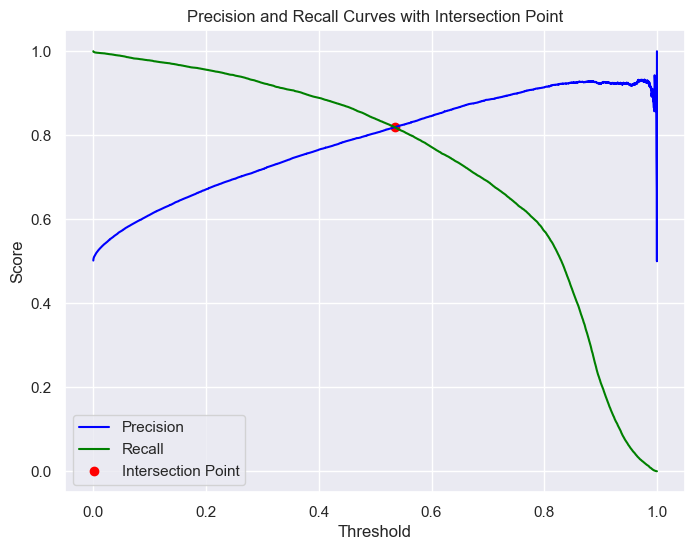

Intersection Threshold: 0.5345


In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Predict probabilities on the validation set
y_prob = log_model_pca.predict_proba(df_train_pca)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_resampled_ada, y_prob)

# Calculate the area under the precision-recall curve (AUC)
pr_auc = auc(recall, precision)

# Find the threshold where precision and recall intersect
intersection_threshold = thresholds[np.argmax(precision >= recall)]

# Plot precision and recall curves
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.scatter(intersection_threshold, precision[np.argmax(precision >= recall)], color='red', marker='o', label='Intersection Point')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves with Intersection Point')
plt.legend()
plt.show()

print(f"Intersection Threshold: {intersection_threshold:.4f}")

**Since the optimal threshold is very close to the by default threshold of 0.5, we proceed with the by default value of cutt off**

## Random Forest

In [86]:
rf_pca = RandomForestClassifier(random_state=42,max_depth=3)
rf_pca.fit(df_train_pca, y_resampled_ada)

RandomForestClassifier(max_depth=3, random_state=42)

In [87]:
# Making predictions on the training data
y_train_pred_rf = rf_pca.predict(df_train_pca)

# Checking predict probability on PCA data for the training data
train_pred_prob_rf = rf_pca.predict_proba(df_train_pca)[:, 1]

# Evaluating the model on the training data
train_performance_rf = calculate_performance_traindata("Random Forest", y_resampled_ada, y_train_pred_rf, train_pred_prob_rf)

# Display the performance metrics for the training data
print(train_performance_rf)


Random Forest (Train Data):

Precision: 0.7907
Recall: 0.7743
F1 Score: 0.7825
ROC AUC: 0.8625
Accuracy: 0.7840

                 Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Random Forest-Train     0.7907  0.7743    0.7825   0.8625    0.7840


In [88]:
# Making predictions on the test data
y_test_pred_rf = rf_pca.predict(df_test_pca)

# Checking predict probability on PCA data for the test data
test_pred_prob_rf = rf_pca.predict_proba(df_test_pca)[:, 1]

# Evaluating the model on the test data
test_performance_rf = calculate_performance_testdata("Random Forest", y_test, y_test_pred_rf, test_pred_prob_rf)

# Display the performance metrics for the test data
print(test_performance_rf)


Random Forest (Test Data):

Precision: 0.2244
Recall: 0.7621
F1 Score: 0.3467
ROC AUC: 0.8484
Accuracy: 0.7823

                Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Random Forest-Test     0.2244  0.7621    0.3467   0.8484    0.7823


### Hyperparameter Tuning
**Tuning above random forest model for maximising recall using different values for the involved hyperparameters**

In [89]:
# Define the parameter grid for randomized search
param_dist = {
    'n_estimators': [10,25,50,75],
    'max_depth': [2,3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Create the RandomizedSearchCV object with recall as the scoring metric
random_search_recall = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist, 
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='recall',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data
random_search_recall.fit(df_train_pca, y_resampled_ada)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search_recall.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'n_estimators': 25, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}


In [90]:
## Tuned random forest=
rf_pca_tun = RandomForestClassifier(random_state=42, **random_search_recall.best_params_)
rf_pca_tun.fit(df_train_pca, y_resampled_ada)

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=25,
                       random_state=42)

In [91]:
# Making predictions on the training data
y_train_pred_rf_tun = rf_pca_tun.predict(df_train_pca)

# Checking predict probability on PCA data for the training data
train_pred_prob_rf_tun = rf_pca_tun.predict_proba(df_train_pca)[:, 1]

# Evaluating the model on the training data
train_performance_rf_tun = calculate_performance_traindata("Random Forest", y_resampled_ada, y_train_pred_rf_tun, train_pred_prob_rf_tun)

# Display the performance metrics for the training data
print(train_performance_rf_tun)

Random Forest (Train Data):

Precision: 0.8113
Recall: 0.8223
F1 Score: 0.8167
ROC AUC: 0.8905
Accuracy: 0.8149

                 Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Random Forest-Train     0.8113  0.8223    0.8167   0.8905    0.8149


In [92]:
# Making predictions on the test data
y_test_pred_rf_tun = rf_pca_tun.predict(df_test_pca)

# Checking predict probability on PCA data for the test data
test_pred_prob_rf_tun = rf_pca_tun.predict_proba(df_test_pca)[:, 1]

# Evaluating the model on the test data
test_performance_rf_tun = calculate_performance_testdata("Random Forest", y_test, y_test_pred_rf_tun, test_pred_prob_rf_tun)

# Display the performance metrics for the test data
print(test_performance_rf_tun)

Random Forest (Test Data):

Precision: 0.2401
Recall: 0.7841
F1 Score: 0.3676
ROC AUC: 0.8643
Accuracy: 0.7956

                Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Random Forest-Test     0.2401  0.7841    0.3676   0.8643    0.7956


## Gradient Boosting

In [93]:
gb_churn = GradientBoostingClassifier(random_state=42, subsample=0.8)
gb_churn.fit(df_train_pca, y_resampled_ada)

GradientBoostingClassifier(random_state=42, subsample=0.8)

In [94]:
gb_churn.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 0.8,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [95]:
# Making predictions on the training data
y_train_pred_gb = gb_churn.predict(df_train_pca)

# Checking predict probability on PCA data for the training data
train_pred_prob_gb = gb_churn.predict_proba(df_train_pca)[:, 1]

# Evaluating the model on the training data
train_performance_gb = calculate_performance_traindata("Gradient boosting", y_resampled_ada, y_train_pred_gb, train_pred_prob_gb)

# Display the performance metrics for the training data
print(train_performance_gb)

Gradient boosting (Train Data):

Precision: 0.8446
Recall: 0.8584
F1 Score: 0.8515
ROC AUC: 0.9225
Accuracy: 0.8497

                     Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Gradient boosting-Train     0.8446  0.8584    0.8515   0.9225    0.8497


In [96]:
# Making predictions on the test data
y_test_pred_gb = gb_churn.predict(df_test_pca)

# Checking predict probability on PCA data for the test data
test_pred_prob_gb = gb_churn.predict_proba(df_test_pca)[:, 1]

# Evaluating the model on the test data
test_performance_gb = calculate_performance_testdata("Gradient Boosting", y_test, y_test_pred_gb, test_pred_prob_gb)

# Display the performance metrics for the test data
print(test_performance_gb)

Gradient Boosting (Test Data):

Precision: 0.2759
Recall: 0.8106
F1 Score: 0.4116
ROC AUC: 0.8903
Accuracy: 0.8244

                    Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Gradient Boosting-Test     0.2759  0.8106    0.4116   0.8903    0.8244


### Hyperparameter Tuning
**Tuning above gradient boosting model to improve test recall and reduce the difference between train and test recall**

In [97]:
# Define the parameter grid for randomized search
param_dist = {
    'n_estimators': [25, 50, 75, 100],
    'learning_rate': [0.01, 0.03, 0.04, 0.05],
    'max_depth': [2, 3 ,5]
}

# Create the GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42, subsample=0.8)

# Create the RandomizedSearchCV object with recall as the scoring metric
random_search_recall_gb = RandomizedSearchCV(
    gb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the random search to the data
random_search_recall_gb.fit(df_train_pca, y_resampled_ada)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search_recall_gb.best_params_)

start_time = time.time()
for i in range(1000):
    pass

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}


In [98]:
gb_churn_tun = GradientBoostingClassifier(random_state=42, **random_search_recall_gb.best_params_, subsample=0.8)
gb_churn_tun.fit(df_train_pca, y_resampled_ada)

GradientBoostingClassifier(learning_rate=0.05, random_state=42, subsample=0.8)

In [99]:
# Making predictions on the training data
y_train_pred_gb_tun = gb_churn_tun.predict(df_train_pca)

# Checking predict probability on PCA data for the training data
train_pred_prob_gb_tun = gb_churn_tun.predict_proba(df_train_pca)[:, 1]

# Evaluating the model on the training data
train_performance_gb_tun = calculate_performance_traindata("Gradient Boosting", y_resampled_ada, y_train_pred_gb_tun, train_pred_prob_gb_tun)

# Display the performance metrics for the training data
print(train_performance_gb_tun)

Gradient Boosting (Train Data):

Precision: 0.8283
Recall: 0.8283
F1 Score: 0.8283
ROC AUC: 0.9023
Accuracy: 0.8277

                     Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Gradient Boosting-Train     0.8283  0.8283    0.8283   0.9023    0.8277


In [100]:
# Making predictions on the test data
y_test_pred_gb_tun = gb_churn_tun.predict(df_test_pca)

# Checking predict probability on PCA data for the test data
test_pred_prob_gb_tun = gb_churn_tun.predict_proba(df_test_pca)[:, 1]

# Evaluating the model on the test data
test_performance_gb_tun = calculate_performance_testdata("Gradient Boosting", y_test, y_test_pred_gb_tun, test_pred_prob_gb_tun)

# Display the performance metrics for the test data
print(test_performance_gb_tun)

Gradient Boosting (Test Data):

Precision: 0.2647
Recall: 0.8135
F1 Score: 0.3994
ROC AUC: 0.8849
Accuracy: 0.8146

                    Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Gradient Boosting-Test     0.2647  0.8135    0.3994   0.8849    0.8146


## XG BOOST

In [101]:
# Create the XGBoost classifier
xgb_churn = xgb.XGBClassifier(random_state=42, subsample=0.8)

# Fit the model to the training data
xgb_churn.fit(df_train_pca, y_resampled_ada)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [102]:
# Making predictions on the training data
y_train_pred_xgb = xgb_churn.predict(df_train_pca)

# Checking predict probability on PCA data for the training data
train_pred_prob_xgb = xgb_churn.predict_proba(df_train_pca)[:, 1]

# Evaluating the model on the training data
train_performance_xgb = calculate_performance_traindata("XG boost", y_resampled_ada, y_train_pred_xgb, train_pred_prob_xgb)

# Display the performance metrics for the training data
print(train_performance_xgb)

XG boost (Train Data):

Precision: 0.9789
Recall: 0.9976
F1 Score: 0.9881
ROC AUC: 0.9992
Accuracy: 0.9880

            Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  XG boost-Train     0.9789  0.9976    0.9881   0.9992    0.9880


In [103]:
# Making predictions on the test data
y_test_pred_xgb = xgb_churn.predict(df_test_pca)

# Checking predict probability on PCA data for the test data
test_pred_prob_xgb = xgb_churn.predict_proba(df_test_pca)[:, 1]

# Evaluating the model on the test data
test_performance_xgb = calculate_performance_testdata("XG Boost", y_test, y_test_pred_xgb, test_pred_prob_xgb)

# Display the performance metrics for the test data
print(test_performance_xgb)

XG Boost (Test Data):

Precision: 0.3863
Recall: 0.6608
F1 Score: 0.4875
ROC AUC: 0.8786
Accuracy: 0.8947

           Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  XG Boost-Test     0.3863  0.6608    0.4875   0.8786    0.8947


**The above XG boost model is overfitting as train recall is 0.9976 and test recall is 0.6608**

### Hyperparameter Tuning
**Tuning above XG Boost model for reducing overfitting**

In [104]:
# Define the parameter grid for randomized search
param_dist = {
    'n_estimators': [25, 50, 75, 100],
    'learning_rate': [0.01, 0.02, 0.03, 0.04],
    'max_depth': [2, 3, 5],
    'reg_lambda': [0.08, 0.1, 0.3 ,0.5],
    'min_child_weight': [3,4,5,6],
    'gamma': [0.4,0.5,0.6,0.7]
}

# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42, subsample=0.8)

# Create the RandomizedSearchCV object with recall as the scoring metric
random_search_recall_xgb = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the random search to the data
random_search_recall_xgb.fit(df_train_pca, y_resampled_ada)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search_recall_xgb.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'reg_lambda': 0.3, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0.5}


In [105]:
# Create the XGBoost classifier
xgb_churn_tun = xgb.XGBClassifier(random_state=42, **random_search_recall_xgb.best_params_,subsample=0.8)

xgb_churn_tun.fit(df_train_pca, y_resampled_ada)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [106]:
# Making predictions on the training data
y_train_pred_xgb_tun = xgb_churn_tun.predict(df_train_pca)

# Checking predict probability on PCA data for the training data
train_pred_prob_xgb_tun = xgb_churn_tun.predict_proba(df_train_pca)[:, 1]

# Evaluating the model on the training data
train_performance_xgb_tun = calculate_performance_traindata("XG Boost", y_resampled_ada, y_train_pred_xgb_tun, train_pred_prob_xgb_tun)

# Display the performance metrics for the training data
print(train_performance_xgb_tun)

XG Boost (Train Data):

Precision: 0.8500
Recall: 0.8627
F1 Score: 0.8563
ROC AUC: 0.9264
Accuracy: 0.8547

            Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  XG Boost-Train     0.8500  0.8627    0.8563   0.9264    0.8547


In [107]:
# Making predictions on the test data
y_test_pred_xgb_tun = xgb_churn_tun.predict(df_test_pca)

# Checking predict probability on PCA data for the test data
test_pred_prob_xgb_tun = xgb_churn_tun.predict_proba(df_test_pca)[:, 1]

# Evaluating the model on the test data
test_performance_xgb_tun = calculate_performance_testdata("XG Boost", y_test, y_test_pred_xgb_tun, test_pred_prob_xgb_tun)

# Display the performance metrics for the test data
print(test_performance_xgb_tun)

XG Boost (Test Data):

Precision: 0.2757
Recall: 0.7930
F1 Score: 0.4091
ROC AUC: 0.8864
Accuracy: 0.8264

           Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  XG Boost-Test     0.2757  0.7930    0.4091   0.8864    0.8264


# Comparing Models Prediction Models

In [108]:
# Creating DataFrames for performance metrics
train_performance_df_log = pd.DataFrame(train_performance_df, index=[0])
test_performance_df_log = pd.DataFrame(test_performance_df, index=[0])
train_performance_df_rf = pd.DataFrame(train_performance_rf_tun, index=[0])
test_performance_df_rf = pd.DataFrame(test_performance_rf_tun, index=[0])
train_performance_df_xgb = pd.DataFrame(train_performance_xgb_tun, index=[0])
test_performance_df_xgb = pd.DataFrame(test_performance_xgb_tun, index=[0])
train_performance_df_gb = pd.DataFrame(train_performance_gb_tun, index=[0])
test_performance_df_gb = pd.DataFrame(test_performance_gb_tun, index=[0])

# Concatenate the DataFrames
combined_performance_df = pd.concat([train_performance_df_log,test_performance_df_log,train_performance_df_rf,test_performance_df_rf,train_performance_df_xgb,test_performance_df_xgb, train_performance_df_gb, test_performance_df_gb], keys=['Train_Log', 'Test_Log', 'Train_RF', 'Test_RF', 'Train_XGB', 'Test_XGB', 'Train_GB', 'Test_GB'])

# Display the combined performance metrics
combined_performance_df_reset = combined_performance_df.reset_index(drop=True)
display(combined_performance_df_reset)


Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Logistic Regression-Train     0.8050  0.8395    0.8219   0.8926    0.8175
1   Logistic Regression-Test     0.2485  0.8561    0.3852   0.8925    0.7929
2        Random Forest-Train     0.8113  0.8223    0.8167   0.8905    0.8149
3         Random Forest-Test     0.2401  0.7841    0.3676   0.8643    0.7956
4             XG Boost-Train     0.8500  0.8627    0.8563   0.9264    0.8547
5              XG Boost-Test     0.2757  0.7930    0.4091   0.8864    0.8264
6    Gradient Boosting-Train     0.8283  0.8283    0.8283   0.9023    0.8277
7     Gradient Boosting-Test     0.2647  0.8135    0.3994   0.8849    0.8146

# Model Building for Feature Importance

## Random Forest

In [109]:
rf_fs = RandomForestClassifier(random_state=42,max_depth=3)
rf_fs.fit(X_resampled_ada, y_resampled_ada)

RandomForestClassifier(max_depth=3, random_state=42)

In [110]:
# Making predictions on the training data
y_train_pred_rf_fs = rf_fs.predict(X_resampled_ada)

# Checking predict probability on PCA data for the training data
train_pred_prob_rf_fs = rf_fs.predict_proba(X_resampled_ada)[:, 1]

# Evaluating the model on the training data
train_performance_rf_fs = calculate_performance_traindata("Random Forest for feature selection", y_resampled_ada, y_train_pred_rf_fs, train_pred_prob_rf_fs)

# Display the performance metrics for the training data
print(train_performance_rf_fs)


Random Forest for feature selection (Train Data):

Precision: 0.8664
Recall: 0.7819
F1 Score: 0.8220
ROC AUC: 0.9134
Accuracy: 0.8301

                                       Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Random Forest for feature selection-Train     0.8664  0.7819    0.8220   0.9134    0.8301


In [111]:
# Making predictions on the test data
y_test_pred_rf_fs = rf_fs.predict(X_test_scale)

# Checking predict probability on PCA data for the test data
test_pred_prob_rf_fs = rf_fs.predict_proba(X_test_scale)[:, 1]

# Evaluating the model on the test data
test_performance_rf_fs = calculate_performance_testdata("Random Forest for feature selection", y_test, y_test_pred_rf_fs, test_pred_prob_rf_fs)

# Display the performance metrics for the test data
print(test_performance_rf_fs)

Random Forest for feature selection (Test Data):

Precision: 0.3380
Recall: 0.7797
F1 Score: 0.4716
ROC AUC: 0.9080
Accuracy: 0.8676

                                      Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Random Forest for feature selection-Test     0.3380  0.7797    0.4716   0.9080    0.8676


### Hyperparameter Tuning
**Tuning above random forest model for feature selection with the aim of increasing recall**

In [112]:
# Define the parameter grid for randomized search
param_dist = {
    'n_estimators': [10,25,50,75,100],
    'max_depth': [2,3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Create the RandomizedSearchCV object with recall as the scoring metric
random_search_recall_fs = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist, 
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='recall',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data
random_search_recall_fs.fit(X_resampled_ada, y_resampled_ada)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search_recall_fs.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5}


In [113]:
rf_fs_tun = RandomForestClassifier(random_state=42,**random_search_recall_fs.best_params_)
rf_fs_tun.fit(X_resampled_ada, y_resampled_ada)

RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=10, random_state=42)

In [114]:
# Making predictions on the training data
y_train_pred_rf_fs_tun = rf_fs_tun.predict(X_resampled_ada)

# Checking predict probability on PCA data for the training data
train_pred_prob_rf_fs_tun = rf_fs_tun.predict_proba(X_resampled_ada)[:, 1]

# Evaluating the model on the training data
train_performance_rf_fs_tun = calculate_performance_traindata("Random Forest for feature selection", y_resampled_ada, y_train_pred_rf_fs_tun, train_pred_prob_rf_fs_tun)

# Display the performance metrics for the training data
print(train_performance_rf_fs_tun)

Random Forest for feature selection (Train Data):

Precision: 0.8871
Recall: 0.8485
F1 Score: 0.8674
ROC AUC: 0.9368
Accuracy: 0.8698

                                       Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Random Forest for feature selection-Train     0.8871  0.8485    0.8674   0.9368    0.8698


In [115]:
# Making predictions on the test data
y_test_pred_rf_fs_tun = rf_fs_tun.predict(X_test_scale)

# Checking predict probability on PCA data for the test data
test_pred_prob_rf_fs_tun = rf_fs_tun.predict_proba(X_test_scale)[:, 1]

# Evaluating the model on the test data
test_performance_rf_fs_tun = calculate_performance_testdata("Random Forest for feature selection", y_test, y_test_pred_rf_fs_tun, test_pred_prob_rf_fs_tun)

# Display the performance metrics for the test data
print(test_performance_rf_fs_tun)

Random Forest for feature selection (Test Data):

Precision: 0.3623
Recall: 0.7900
F1 Score: 0.4968
ROC AUC: 0.9145
Accuracy: 0.8787

                                      Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Random Forest for feature selection-Test     0.3623  0.7900    0.4968   0.9145    0.8787


## XGB Boost

In [116]:
# Create the XGBoost classifier
xgb_fs = xgb.XGBClassifier(random_state=42, subsample=0.8)

# Fit the model to the training data
xgb_fs.fit(X_resampled_ada, y_resampled_ada)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [117]:
# Making predictions on the training data
y_train_pred_xgb_fs = xgb_fs.predict(X_resampled_ada)

# Checking predict probability on PCA data for the training data
train_pred_prob_xgb_fs = xgb_fs.predict_proba(X_resampled_ada)[:, 1]

# Evaluating the model on the training data
train_performance_xgb_fs = calculate_performance_traindata("XG boost", y_resampled_ada, y_train_pred_xgb_fs, train_pred_prob_xgb_fs)

# Display the performance metrics for the training data
print(train_performance_xgb_fs)

XG boost (Train Data):

Precision: 0.9967
Recall: 0.9959
F1 Score: 0.9963
ROC AUC: 0.9999
Accuracy: 0.9963

            Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  XG boost-Train     0.9967  0.9959    0.9963   0.9999    0.9963


In [118]:
# Making predictions on the test data
y_test_pred_xgb_fs = xgb_fs.predict(X_test_scale)

# Checking predict probability on PCA data for the test data
test_pred_prob_xgb_fs = xgb_fs.predict_proba(X_test_scale)[:, 1]

# Evaluating the model on the test data
test_performance_xgb_fs = calculate_performance_testdata("Random Forest for feature selection", y_test, y_test_pred_xgb_fs, test_pred_prob_xgb_fs)

# Display the performance metrics for the test data
print(test_performance_xgb_fs)

Random Forest for feature selection (Test Data):

Precision: 0.6012
Recall: 0.5756
F1 Score: 0.5881
ROC AUC: 0.9179
Accuracy: 0.9389

                                      Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Random Forest for feature selection-Test     0.6012  0.5756    0.5881   0.9179    0.9389


**The above XG Boost model is overfitting as recall for train is 0.9959 and for test is 0.5756**

### Hyperparameter Tuning
**Tuning above XG Boost model for feature importance to reduce overfitting.** We noticed that the default learning rate of 0.1 is resulting in very good train performance but poor test performance. Hence, we are restricting our parameter grid to lower values of learning rates to avoid the overfitted model being prioritized. 

In [119]:
# Define the parameter grid for randomized search
param_dist = {
    'n_estimators': [10, 20,30, 40],
    'learning_rate': [0.005, 0.01, 0.015, 0.02],
    'max_depth': [2, 3, 4],
    'min_child_weight': [3,4,5,6],
    'gamma': [0.3,0.4,0.5,0.6],
    'reg_lambda': [0.05, 0.08, 0.1, 0.2] 
}

# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42, subsample=0.8)

# Create the RandomizedSearchCV object with recall as the scoring metric
random_search_recall_xgb_fs = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the random search to the data
random_search_recall_xgb_fs.fit(X_resampled_ada, y_resampled_ada)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search_recall_xgb_fs.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'reg_lambda': 0.2, 'n_estimators': 20, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.4}


In [120]:
# Create the XGBoost classifier
xgb_fs_tun = xgb.XGBClassifier(random_state=42, subsample=0.8, **random_search_recall_xgb_fs.best_params_)

# Fit the model to the training data
xgb_fs_tun.fit(X_resampled_ada, y_resampled_ada)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [121]:
# Making predictions on the training data
y_train_pred_xgb_fs_tun = xgb_fs_tun.predict(X_resampled_ada)

# Checking predict probability on PCA data for the training data
train_pred_prob_xgb_fs_tun = xgb_fs_tun.predict_proba(X_resampled_ada)[:, 1]

# Evaluating the model on the training data
train_performance_xgb_fs_tun = calculate_performance_traindata("XG boost for feature selection", y_resampled_ada, y_train_pred_xgb_fs_tun, train_pred_prob_xgb_fs_tun)

# Display the performance metrics for the training data
print(train_performance_xgb_fs_tun)

XG boost for feature selection (Train Data):

Precision: 0.8446
Recall: 0.8718
F1 Score: 0.8580
ROC AUC: 0.9184
Accuracy: 0.8552

                                  Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  XG boost for feature selection-Train     0.8446  0.8718    0.8580   0.9184    0.8552


In [122]:
# Making predictions on the test data
y_test_pred_xgb_fs_tun = xgb_fs_tun.predict(X_test_scale)

# Checking predict probability on PCA data for the test data
test_pred_prob_xgb_fs_tun = xgb_fs_tun.predict_proba(X_test_scale)[:, 1]

# Evaluating the model on the test data
test_performance_xgb_fs_tun = calculate_performance_testdata("XG Boost for feature selection", y_test, y_test_pred_xgb_fs_tun, test_pred_prob_xgb_fs_tun)

# Display the performance metrics for the test data
print(test_performance_xgb_fs_tun)

XG Boost for feature selection (Test Data):

Precision: 0.2921
Recall: 0.8253
F1 Score: 0.4315
ROC AUC: 0.8965
Accuracy: 0.8352

                                 Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  XG Boost for feature selection-Test     0.2921  0.8253    0.4315   0.8965    0.8352


# Comparing Feature Importance Models

In [123]:
# Creating DataFrames for performance metrics

train_performance_fs_rf = pd.DataFrame(train_performance_rf_fs_tun, index=[0])
test_performance_fs_rf = pd.DataFrame(test_performance_rf_fs_tun, index=[0])
train_performance_fs_xgb = pd.DataFrame(train_performance_xgb_fs_tun, index=[0])
test_performance_fs_xgb = pd.DataFrame(test_performance_xgb_fs_tun, index=[0])


# Concatenate the DataFrames
combined_performance_df = pd.concat([train_performance_fs_rf,test_performance_fs_rf,train_performance_fs_xgb,test_performance_fs_xgb], keys=['Train_RF', 'Test_RF', 'Train_XGB', 'Test_XGB'])

# Display the combined performance metrics
combined_performance_df_reset = combined_performance_df.reset_index(drop=True)
display(combined_performance_df_reset)

Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
0  Random Forest for feature selection-Train     0.8871  0.8485    0.8674   0.9368    0.8698
1   Random Forest for feature selection-Test     0.3623  0.7900    0.4968   0.9145    0.8787
2       XG boost for feature selection-Train     0.8446  0.8718    0.8580   0.9184    0.8552
3        XG Boost for feature selection-Test     0.2921  0.8253    0.4315   0.8965    0.8352

**Since XG Boost model is  giving best recall, we will go with it and check its feature importance** 

In [124]:
#Creating a Feature importance dataframe
Feature_importance = pd.DataFrame({"columns":X_resampled_ada.columns,"feature_importance":xgb_fs_tun.feature_importances_})
#checking top 15 important features
fi = Feature_importance.sort_values(by="feature_importance",ascending=False).head(20)
display(fi)

columns  feature_importance
65         loc_ic_mou_8              0.4435
14        roam_og_mou_8              0.1996
80       total_ic_mou_8              0.0750
137           fb_user_8              0.0448
101  last_day_rch_amt_8              0.0405
95     total_rech_amt_8              0.0382
98       max_rech_amt_8              0.0276
53       total_og_mou_8              0.0272
11        roam_ic_mou_8              0.0190
22     loc_og_t2f_mou_7              0.0126
92     total_rech_num_8              0.0124
48          og_others_6              0.0122
123        monthly_2g_6              0.0103
83         spl_ic_mou_8              0.0085
32     std_og_t2t_mou_8              0.0072
46         spl_og_mou_7              0.0071
17     loc_og_t2t_mou_8              0.0066
43         isd_og_mou_7              0.0060
56     loc_ic_t2t_mou_8              0.0005
105     count_rech_2g_6              0.0005

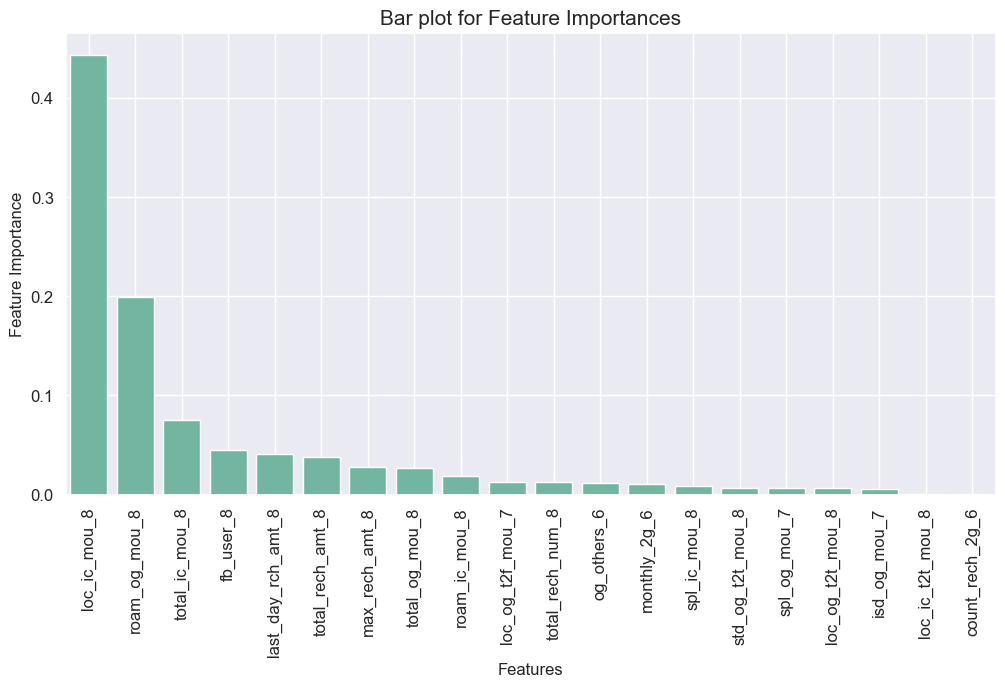

In [125]:
#Plot to show the feature importance
plt.figure(figsize=[12,6])
sns.barplot(x = "columns",y="feature_importance",data=fi)
plt.title("Bar plot for Feature Importances",size=15)
plt.xticks(rotation="vertical")
plt.ylabel("Feature Importance",size=12)
plt.xlabel("Features",size=12)
plt.tick_params(size=5,labelsize = 12) # Tick size in both X and Y axes
plt.grid(0.3)

# Summary

This section summarizes all the tasks performed as part of this case study and presents their findings in a concise manner.

We started off with understanding the business problem statement and understanding the data at hand to identify how it will help us in offering predictions and prescribing solutions to the problem at hand. We classified the customers as Churn/Not-Churn based on their usage of services with the hope of building a supervised learning model that can predict Churn during the good and action phases before it is too late for the company to try and retain the customer.

We proceeded with data cleaning tasks which included feature selection, handling missing values, creating derived features to identify high-value customers, and dropping redundant and low variability columns. Exploratory data analysis was performed and visualizations were created to better understand the data with respect to the target variable.

Data was prepared for modelling by separating 30% of it to test any of the built models so that we can evaluate model performances. We then proceed to scale all the features of the dataset using z-Standardization. A basic logistic regression model was created which will act as a yard stick to measure rest of the models. Following table summarizes the model evaluation metrics for Logistic Regression (Basic Model) on the test data:


| Basic Model         |Accuracy  | F1 Score |  Recall   |  Precision |
|---------------------|----------|----------|-----------|------------|
| Logistic Regression |0.9349    | 0.4179   |  0.3084   |  0.6481    |


It is observed that though the basic model has accuracy, it performs poorly on rest of the metrics. Also, we have identified class imbalance of the target variable during our analysis and see that the minority class isn't being correctly predicted. Hence we proceed with handling the class imbalance using various techniques. The following table contains the summary of model evaluation metrics obtained by rebuilding the basic logistic regression model after applying various imbalance techniques. This summary helps us decide which imbalance handling technique is best suited for our data:

| Sampling Technique   | Accuracy | F1 Score | Recall  | Precision  |
|-----------------------|----------|----------|---------|-----------|
| Random Undersampling  | 0.7957   | 0.3876   | 0.8532  | 0.2508    |
| Random Oversampling   | 0.8073   | 0.4003   | 0.8488  | 0.2619    |
| TOMEK                 | 0.7957   | 0.3876   | 0.8532  | 0.2508    |
| SMOTE                 | 0.8212   | 0.4141   | 0.8341  | 0.2755    |
| ADASYN                | 0.7959   | 0.3899   | 0.8605  | 0.2520    |
| SMOTE+TOMEK           | 0.8196   | 0.4116   | 0.8326  | 0.2734    |


The evaluation metric that is most important to us is Recall. This decision has been made with our business understanding that we don't want to miss identifying any of the churn customers and we don't mind identifying a non-churn customer as churn. That is we want to reduce the number of "False Negatives" that we get and maximizing recall will do exactly that. So based on recall, we see that ADASYN (Adaptive Synthetic Sampling) gives the best recall and helps in getting least number of "False Negatives". Hence we proceed with the data transformed using ADASYN.

Since the dataset has 145 features, we choose to use Principal Component Analysis to preserve maximum variation in as little number of columns as possible. After performing PCA we observe that 53 features are able to explain 90% of the variability in the data. Thus 53 derived principal components are used for the rest of the model building process.

We proceed to build various models to find the model which gives us best recall and hence can be used to identify and predict a potential churn customer in real time. Each model is built and finetuned using Randomized Search Method to get the best set of hyperparameters. Following are the model evaluation metrics obtained for the built models:

| Model                      | Precision | Recall | F1 Score | ROC AUC | Accuracy |
|----------------------------|-----------|--------|----------|---------|----------|
| Logistic Regression (Train)| 0.8050    | 0.8395 | 0.8219   | 0.8926  | 0.8175   |
| Logistic Regression (Test) | 0.2485    | 0.8561 | 0.3852   | 0.8925  | 0.7929   |
| Random Forest (Train)      | 0.8113    | 0.8223 | 0.8167   | 0.8905  | 0.8149   |
| Random Forest (Test)       | 0.2401    | 0.7841 | 0.3676   | 0.8643  | 0.7956   |
| XG Boost (Train)           | 0.8500    | 0.8627 | 0.8563   | 0.9264  | 0.8547   |
| XG Boost (Test)            | 0.2757    | 0.7930 | 0.4091   | 0.8864  | 0.8264   |
| Gradient Boosting (Train)  | 0.8283    | 0.8283 | 0.8283   | 0.9023  | 0.8277   |
| Gradient Boosting (Test)   | 0.2647    | 0.8135 | 0.3994   | 0.8849  | 0.8146   |

We observe that the precision and F1 score are overfitting for all the models (as observed from the huge difference between train and test values). However other metrics are comparable for the models. Since we are interested in maximizing the recall, we conclude that the logistic regression model is the best model for predicting Churn. 

Now we wish to identify the most important features causing churn. This is is done by using two models with the original features, comparing their performances, and then identifying the feature importances of those models. Following is the summary of the models created for feature importance understanding:

| Model                 | Precision | Recall | F1 Score | ROC AUC | Accuracy |
|-----------------------|-----------|--------|----------|---------|----------|
| Random Forest (Train) | 0.8871    | 0.8485 | 0.8674   | 0.9368  | 0.8698   |
| Random Forest (Test)  | 0.3623    | 0.7900 | 0.4968   | 0.9145  | 0.8787   |
| XG boost (Train)      | 0.8446    | 0.8718 | 0.8580   | 0.9184  | 0.8552   |
| XG Boost (Test)       | 0.2921    | 0.8253 | 0.4315   | 0.8965  | 0.8352   |


We use XG Boost Model to identify the best features. Features with over 1% importance are given below, they contribute to over 96% of total feature importances.

| Index | Columns            | Feature Importance |
|-------|--------------------|---------------------|
| 65    | loc_ic_mou_8       | 0.4435              |
| 14    | roam_og_mou_8      | 0.1996              |
| 80    | total_ic_mou_8     | 0.0750              |
| 137   | fb_user_8          | 0.0448              |
| 101   | last_day_rch_amt_8 | 0.0405              |
| 95    | total_rech_amt_8   | 0.0382              |
| 98    | max_rech_amt_8     | 0.0276              |
| 53    | total_og_mou_8     | 0.0272              |
| 11    | roam_ic_mou_8      | 0.0190              |
| 22    | loc_og_t2f_mou_7   | 0.0126              |
| 92    | total_rech_num_8   | 0.0124              |
| 48    | og_others_6        | 0.0122              |
| 123   | monthly_2g_6       | 0.0103              |

This concludes our case study. The following section contains recommendations we prescribe.

# Recommendations

- We notice that the top features are all of the month August insinuating that most recent customer behaviour is the best predictor of "Churn". So we advice the company to adopt a dynamic strategy for model training where it keeps incorporating the most recent data in the model for prediction. Static models won't work well with this data and for this business problem.

- We also notice that the `mou`, `recharge` and `data` columns are important determinants of churn. The company should closely monitor these features and create new plans to attract and encourage more usage of these services.

- For actually predicting churn, Logistic Regression model after performing PCA, works well. XG Boost performs well as well, it in fact exhibits better train performance than Logistic Regression, but Logistic Regression performs better on the test data. It is therefore adviced to use logistic regression model instead of any other more complex model. This will be both easy to deploy and efficient. 

- In a phase when the company wishes to aggressively retain customers, we can further reduce the cut-off probability for predicting "Churn" using the Logistic Regression model. This allows us to maximize the number of true positives and also increase the Recall.
